# Advance Machine Learning

## PUBG Finish Placement Prediction

### Team Member
#### Palazzi Bruno - 806908
#### Giacomo Villa - 807462

# TO DO


# Attributes
* assists: Number of enemy players this player damaged that were killed by teammates.
* boosts: Number of boost items used.
* damageDealt: Total damage dealt. Note: Self inflicted damage is subtracted.
* DBNOs: Number of enemy players knocked.
* headshotKills: Number of enemy players killed with headshots.
* heals: Number of healing items used.
* killPlace: Ranking in match of number of enemy players killed.
* killPoints: Kills-based external ranking of player.
* kills: Number of enemy players killed. 
* killStreaks: Max number of enemy players killed in a short amount of time.
* longestKill: Longest distance between player and player killed at time of death.
* matchDuration: Duration of match in seconds.
* matchType: String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches. 
* numGroups: Number of groups we have data for in the match.
* revives: Number of times this player revived teammates.
* rideDistance: Total distance traveled in vehicles measured in meters.
* roadKills: Number of kills while in a vehicle.
* swimDistance: Total distance traveled by swimming measured in meters.
* teamKills: Number of times this player killed a teammate.
* vehicleDestroys: Number of vehicles destroyed.
* walkDistance: Total distance traveled on foot measured in meters.
* weaponsAcquired: Number of weapons picked up.
* winPoints: Win-based external ranking of player. 
* maxPlace: Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements. 

# Libraries

In [1]:
import pandas as pd

from datetime import datetime

import matplotlib.pyplot as plt

import seaborn as sns

import collections

import statistics 

import numpy as np

from pyGPGO.surrogates.RandomForest import RandomForest
from pyGPGO.GPGO import GPGO
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

import keras 
from keras.utils import np_utils
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Input
from keras.utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Using TensorFlow backend.


# Function

In [50]:
def load_data():
    fields = ['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals', 'killPlace',
             'killPoints', 'kills', 'killStreaks', 'longestKill', 'matchDuration', 'matchType', 
              'numGroups', 'revives', 'rideDistance', 'roadKills', 'swimDistance', 'teamKills',
               'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints', 'winPlacePerc']
    data = pd.read_csv('../data/dataset.csv', usecols=fields)
    # data = data['matchType' == 'squad-fpp']
    print("START DATASET")
    print(data.head(5))
    print("NUMBER OF ROWS: ", len(data))
    print("")
    return data

def select_typology(data, typology):
    
    if typology == 'solo-fpp':
        del data['DBNOs']
        del data['revives']
        del data['teamKills']
        
        
    data = data[data.matchType == typology]
    del data['matchType']
    print("SELECT TASK DATASET")
    print(data.head(5))
    print("NUMBER OF ROWS: ", len(data))
    print("")
    
    return data

def transform_task(data):
    labels = list()
    scores = data.winPlacePerc
    for score in scores:
        score = round(score, 2)
        if score >= 0 and score <= 0.2:
            labels.append(0)
        elif score >= 0.21 and score <= 0.4:
            labels.append(1)
        elif score >= 0.41 and score <= 0.6:
            labels.append(2)
        elif score >= 0.61 and score <= 0.8:
            labels.append(3)
        elif score >= 0.81 and score <= 1:
            labels.append(4)
        else:
            print("PROBLEMS VALUES: ", score)
            labels.append(-1)
    
    del data['winPlacePerc']
    
    data['label'] = labels
    
    data = data.drop(data[data.label == -1].index)
    
    print("CHANGE TASK DATASET")
    print(data.head(5))
    print("NUMBER OF ROWS: ", len(data))
    print("")
    return data


def preprocessing_data(dataset):
    
    data = dataset.values.copy()
    
    x = data[:, 0:-1].astype(np.float32) 
    y = data[:, -1]
    y = np_utils.to_categorical(y, 5)
    
    scaler = StandardScaler()
    scaler.fit(data)
    data = scaler.transform(data)
    
    return x, y

def print_correlation_matrix(dataset):
    corr = dataset.corr()
    plt.subplots(figsize=(15, 15))
    sns.set(font_scale=1.1)
    plot = sns.heatmap(corr, xticklabels = corr.columns.values, yticklabels = corr.columns.values,
                      linewidths=.1, vmin=-1, vmax=1, annot=True)
    
def print_distribution(dataset):
    fig1, ax1 = plt.subplots()
    number = dataset["label"].value_counts()
    number = dict(collections.OrderedDict(sorted(number.items())))
    show = list()
    print(number)
    for value in number:
        show.append(number[value])
    print(show)
    ax1.pie(show, explode = (0, 0, 0, 0, 0.2), labels = ['Low', 'Medium-Low', 'Medium', 'Medium-High', 'High'],
            autopct='%1.1f%%', shadow=True, startangle=90)
    ax1.axis('equal')
    plt.show()
    
def print_kills_number(kills):
    
    plt.figure(figsize=(15,10))
    
    plt.title("Kills")
    plt.xlabel("# kills")
    plt.ylabel("times")
    
    kills_number = [0]*10
    names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9+']
    
    for kill in kills:
        if kill >= 10:
            kills_number[9] += 1
        else:
            kills_number[kill] += 1
            
    print(kills_number)
    plot = plt.bar(np.arange(10), height = kills_number, tick_label = names)
    plt.show()

def print_sns_hist(value, name):
    plt.figure(figsize=(15, 10))
    value.name = name
    sns.distplot(value)
    
def print_sns_join_plot(x_value, y_value, dataset):
    sns.jointplot(x_value, y_value, dataset, ratio=3, height=15)
    plt.show()

def print_sns_pairplot(dataset, based):
    plt.figure(figsize=(60, 60))
    sns.set(font_scale=5)
    g = sns.pairplot(dataset, vars=["killPlace", "weaponsAcquired", "kills", "damageDealt", "walkDistance"],
                     hue="label", markers=["o", "x"], height = 10)
    new_labels = ['Low', 'High']
    for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
    for i, j in zip(*np.triu_indices_from(g.axes, 1)):
        g.axes[i, j].set_visible(False)
    plt.show()
    sns.set()
    
def plotConfusionMatrix(y_true, y_pred, classes, normalize, title, cmap = plt.cm.get_cmap("Blues")):
    
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap= cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),

           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

    plt.show(ax)
    
    
def define_net(first_layer, second_layer, third_layer, n_layers, opt, input_size):
    model = Sequential()
    model.add(Dense(first_layer, input_shape = (input_size,), activation='relu'))
    model.add(Dropout(0.4, noise_shape=None, seed=None))
    
    if n_layers == 2:
        model.add(Dense(second_layer, activation='relu'))
        model.add(Dropout(0.4, noise_shape=None, seed=None))
        
    elif n_layers == 3:
        model.add(Dense(second_layer, activation='relu'))
        model.add(Dropout(0.4, noise_shape=None, seed=None))
        model.add(Dense(third_layer, activation='relu'))
        model.add(Dropout(0.4, noise_shape=None, seed=None))
        
    model.add(Dense(5))
    model.add(Activation('softmax'))
    model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])  
    return model

# optimizers:
# 0: SGD, 1: RMSprop, 2: Adagrad, 3: Adadelta
    
def compute_accuracy(conf_lr, conf_mom, conf_rho, conf_n_layers, conf_fl, conf_sl, conf_tl, conf_opt):
    
    kfold = StratifiedKFold(n_splits = 3, shuffle=False)
    history_cross = 0
    
    if conf_opt == 0:
        opt = optimizers.SGD(conf_lr, conf_mom)
        print("{:<21}{:>5}".format("TRY OPTIMIERS: ", "SGD"))
        print("{:<21}{:>5}".format("TRY LEARNING RATE: ", round(conf_lr, 5)))
        print("{:<21}{:>5}".format("TRY MOMENTUM:", round(conf_mom, 5)))
    elif conf_opt == 1:
        opt = optimizers.RMSprop(conf_lr, conf_rho)
        print("{:<21}{:>5}".format("TRY OPTIMIERS: ", "RMSprop"))
        print("{:<21}{:>5}".format("TRY LEARNING RATE: ", round(conf_lr, 5)))
        print("{:<21}{:>5}".format("TRY RHO:", round(conf_rho, 5)))
    elif conf_opt == 2:
        opt = optimizers.Adagrad(conf_lr)
        print("{:<21}{:>5}".format("TRY OPTIMIERS: ", "Adagrad"))
        print("{:<21}{:>5}".format("TRY LEARNING RATE: ", round(conf_lr, 5)))
    elif conf_opt == 3:
        opt = optimizers.Adadelta(conf_lr, conf_rho)
        print("{:<21}{:>5}".format("TRY OPTIMIERS: ", "Adadelta"))
        print("{:<21}{:>5}".format("TRY LEARNING RATE: ", round(conf_lr, 5)))  
        print("{:<21}{:>5}".format("TRY RHO:", round(conf_rho, 5)))
        
    print("{:<21}{:>5}".format("TRY NUMBER LAYERS:", int(conf_n_layers)))
    if int(conf_n_layers) == 1:
        print("{:<21}{:>5}".format("TRY FIRST LAYER: ", int(conf_fl)))
    elif int(conf_n_layers) == 2:
        print("{:<21}{:>5}".format("TRY FIRST LAYER: ", int(conf_fl)))
        print("{:<21}{:>5}".format("TRY SECOND LAYER: ", int(conf_sl)))
    elif int(conf_n_layers) == 3:
        print("{:<21}{:>5}".format("TRY FIRST LAYER: ", int(conf_fl)))
        print("{:<21}{:>5}".format("TRY SECOND LAYER: ", int(conf_sl)))
        print("{:<21}{:>5}".format("TRY FIRST LAYER: ", int(conf_tl)))
  
    print("")

    
    x_train, y_train = preprocessing_data(typology_data)
    
    es = EarlyStopping(monitor='val_accuracy', patience = 5, verbose = 0, restore_best_weights = True)
    
    cvscores = []
    
    fold = 0
    
    label_noOneHot = typology_data.values.copy()[:, -1]
    
    prediction = list()
    labels_real = list()
    prediction_array = list()
    labels_real_array = list()
    global run
    print("{:<26}{:>7}".format("RUN NUMBER: ", run))
    run += 1
    
    for train, test in kfold.split(x_train, label_noOneHot):
        
        print("{:<26}{:>7}".format("FOLD NUMBER: ", fold + 1))
        
        x_test_real, x_val, y_test_real, y_val = train_test_split(x_train[test], y_train[test],
                                                                  test_size = 0.2)
        
        model = define_net(int(conf_fl), int(conf_sl), int(conf_tl), conf_n_layers, opt, 20)
        
        history_cross = model.fit(x_train[train], y_train[train], epochs=200, batch_size=256, verbose = 0, validation_data=(x_val, y_val), 
                                    callbacks = [es])
        
        scores_accuracy = model.evaluate(x_test_real, y_test_real, verbose = 0)
        labels_predict = model.predict_classes(x_test_real)
        
        for predict in labels_predict:
            prediction.append(predict)
        
        for label in y_test_real:    
            labels_real.append(np.where(label == np.amax(label))[0][0])
        
        prediction_array = np.array(prediction)
        labels_real_array = np.array(labels_real)
        
        plotConfusionMatrix(labels_real_array, prediction_array, ['Low', 'Medium-Low', 'Medium', 'Medium-High', 'High'],
                        False, "Confusion Matrix fold: " + str(fold + 1))
        print("{:<26}{:>5}".format("ACCURACY FOLD OBTAIN: ", round(scores_accuracy[1], 6)))
        cvscores.append(scores_accuracy[1])
        
        
        print("{:<26}{:>7}".format("PRECISION LOW: ", round(classification_report(labels_real_array, prediction_array,
                                                                            output_dict = True)['0']['precision'], 6)))
        print("{:<26}{:>7}".format("PRECISION MEDIUM-LOW: ", round(classification_report(labels_real_array, prediction_array,
                                                                            output_dict = True)['1']['precision'], 6)))
        print("{:<26}{:>7}".format("PRECISION MEDIUM: ", round(classification_report(labels_real_array,prediction_array,
                                                                            output_dict = True)['2']['precision'], 6)))
        print("{:<26}{:>7}".format("PRECISION MEDIUM-HIGH: ", round(classification_report(labels_real_array, prediction_array,
                                                                            output_dict = True)['3']['precision'], 6)))
        print("{:<26}{:>7}".format("PRECISION HIGH: ", round(classification_report(labels_real_array, prediction_array,
                                                                            output_dict = True)['4']['precision'], 6)))
        print("{:<26}{:>7}".format("RECALL LOW: ", round(classification_report(labels_real_array, prediction_array,
                                                                            output_dict = True)['0']['recall'], 6)))
        print("{:<26}{:>7}".format("RECALL MEDIUM-LOW: ", round(classification_report(labels_real_array, prediction_array,
                                                                            output_dict = True)['1']['recall'], 6)))
        print("{:<26}{:>7}".format("RECALL MEDIUM: ", round(classification_report(labels_real_array, prediction_array,
                                                                            output_dict = True)['2']['recall'], 6)))
        print("{:<26}{:>7}".format("RECALL MEDIUM-HIGH: ", round(classification_report(labels_real_array, prediction_array,
                                                                            output_dict = True)['3']['recall'], 6)))
        print("{:<26}{:>7}".format("RECALL HIGH: ", round(classification_report(labels_real_array, prediction_array,
                                                                            output_dict = True)['4']['recall'], 6)))
        
        plot_history(history_cross, 'accuracy')
        plot_history(history_cross, 'loss')
        
        
        prediction.clear()
        labels_real.clear()
        
        fold += 1
        
    if len(best_seen) == 0:
        best_seen.append(np.mean(cvscores))
    else:
        if np.mean(cvscores) > max(best_seen):
            best_seen.append(np.mean(cvscores))
        else:
            best_seen.append(best_seen[-1])
    
    print("{:<26}{:>7}".format("ACCURACY OBTAIN: ", round(np.mean(cvscores), 6)))
    print("")
    return (np.mean(cvscores))

def plot_history(network_history, index):
    
    plt.figure(figsize=(15,5)) 
    plt.xlabel('Epochs')
    plt.ylabel(index)
    plt.plot(network_history.history[index])
    plt.plot(network_history.history["val_"+index])
    plt.legend(['Training', 'Validation'], loc='best')

    plt.show()

# Loading Data

In [24]:
data = load_data()
changed_task_data = transform_task(data)
typology_data = select_typology(changed_task_data, 'solo-fpp')

START DATASET
   assists  boosts  damageDealt  DBNOs  headshotKills  heals  killPlace  \
0        0       0         0.00      0              0      0         60   
1        0       0        91.47      0              0      0         57   
2        1       0        68.00      0              0      0         47   
3        0       0        32.90      0              0      0         75   
4        0       0       100.00      0              0      0         45   

   killPoints  kills  killStreaks  ...  revives  rideDistance roadKills  \
0        1241      0            0  ...        0        0.0000         0   
1           0      0            0  ...        0        0.0045         0   
2           0      0            0  ...        0        0.0000         0   
3           0      0            0  ...        0        0.0000         0   
4           0      1            1  ...        0        0.0000         0   

   swimDistance  teamKills  vehicleDestroys  walkDistance  weaponsAcquired  \
0     

# Data Analysis

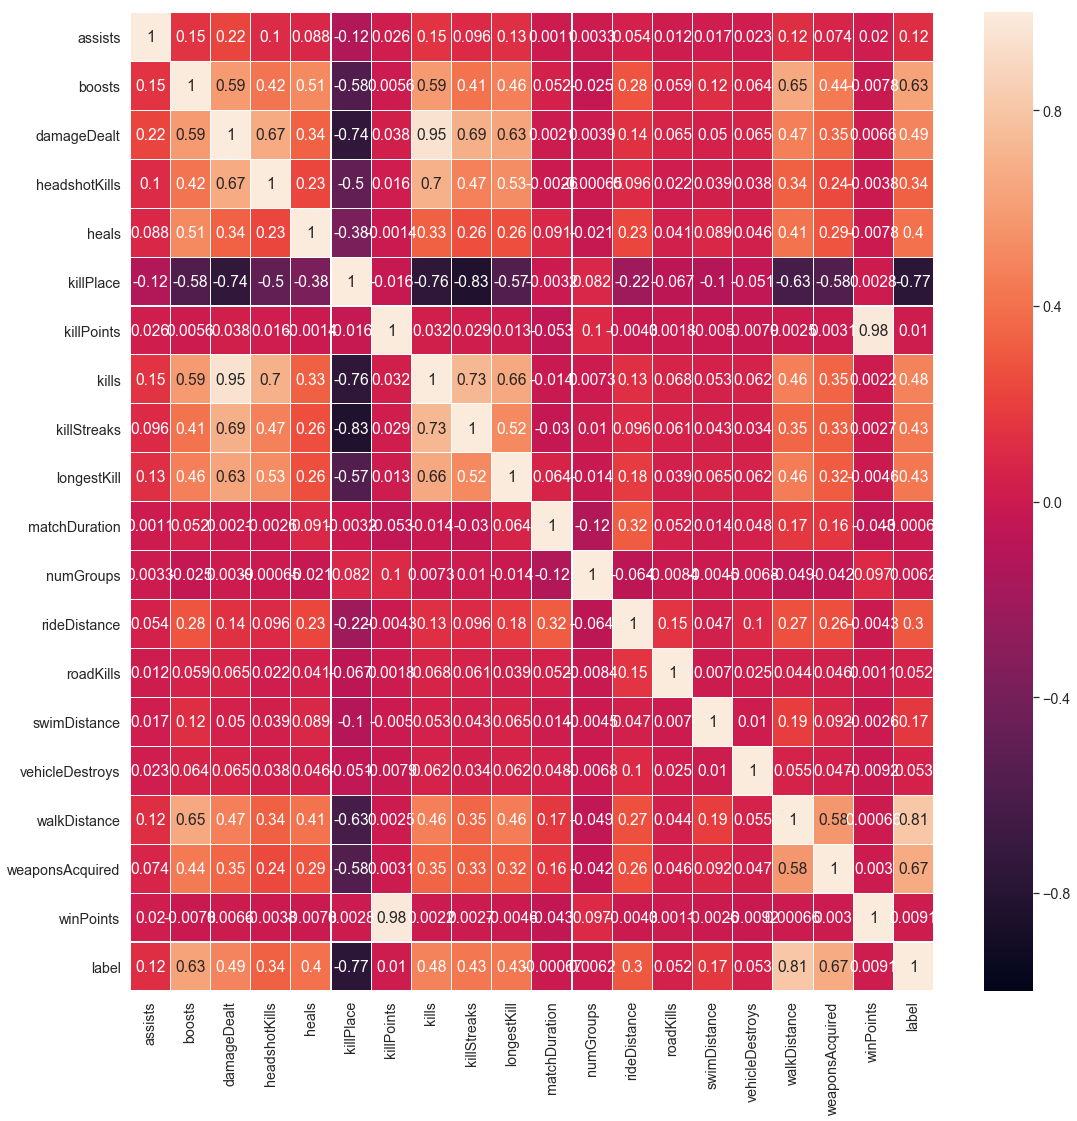

In [52]:
print_correlation_matrix(typology_data)

{0: 117553, 1: 106768, 2: 105774, 3: 101822, 4: 104844}
[117553, 106768, 105774, 101822, 104844]


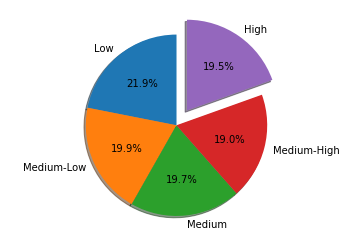

In [26]:
print_distribution(typology_data)

In [ ]:
print("NUMBER OF ROW: ", len(typology_data))

### Kills 

In [ ]:
avg_kill = statistics.mean(typology_data.kills)
print("{:<25}{:>5}".format("AVERAGE KILLS IN A MATCH:", round(avg_kill, 3)))

In [ ]:
print_kills_number(typology_data.kills)

### Walk

In [ ]:
print("{:<20}{:>6}".format("PLAYERS DIED IMMEDIATELY:",len(typology_data[typology_data.walkDistance == 0])))

In [ ]:
print_sns_hist(typology_data.walkDistance, "Walking Distance")

### Damage

In [ ]:
avg_damage = statistics.mean(typology_data.damageDealt)
print("{:<25}{:>5}".format("AVERAGE DAMAGE IN A MATCH: ", round(avg_damage, 3)))

In [ ]:
print_sns_hist(typology_data.damageDealt, "Damage inflicted")

### Walking x Damage

In [ ]:
print_sns_join_plot("walkDistance", "damageDealt", typology_data)

### Walking x Kills

In [ ]:
print_sns_join_plot("walkDistance", "kills", typology_data)

### Damage x Kills

In [ ]:
print_sns_join_plot("damageDealt", "kills", typology_data)

### Walking x Swimming

In [ ]:
print_sns_join_plot("walkDistance", "swimDistance", typology_data)

### Weapons pick up x Kills 

In [ ]:
print_sns_join_plot("weaponsAcquired", "kills", typology_data)

### Boosts x Kills 

In [ ]:
print_sns_join_plot("boosts", "kills", typology_data)

### High vs Low class study

In [ ]:
high = typology_data[typology_data.label == 4]
low = typology_data[typology_data.label == 0]
match_dataset = pd.concat([high[0:1000], low[0:1000]])
print_sns_pairplot(match_dataset, 'label')

In [ ]:
avg_kill = statistics.mean(high.kills)
print("{:<32}{:>5}".format("AVERAGE KILLS FOR PRO PLAYERS:", round(avg_kill, 3)))
print("{:<32}{:>5}".format("MAX KILLS BY PRO PLAYES:", max(high.kills)))
print("{:<32}{:>5}".format("MIN KILLS BY PRO PLAYES:", min(high.kills)))

In [ ]:
print_kills_number(high.kills)

In [ ]:
print_sns_hist(high.walkDistance, "Walking Distance")

In [ ]:
print_sns_hist(high.damageDealt, "Damage inflicted")

# Optimization

In [31]:
param = {'conf_lr': ('cont', [0.001,0.1]), 'conf_mom': ('cont', [0.1, 0.9]), 'conf_rho': ('cont', [0.1, 0.95]),
         'conf_n_layers': ('int', [1, 3]), 'conf_fl': ('int', [150, 300]), 'conf_sl': ('int', [100, 250]),
         'conf_tl': ('int', [50, 100]), 'conf_opt': ('int', [0, 4])}
sur_model = RandomForest()
acq = Acquisition(mode="ExpectedImprovement")

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
TRY OPTIMIERS:         SGD
TRY LEARNING RATE:   0.02899
TRY MOMENTUM:        0.73938
TRY NUMBER LAYERS:       2
TRY FIRST LAYER:       169
TRY SECOND LAYER:      110

RUN NUMBER:                     1
FOLD NUMBER:                    1


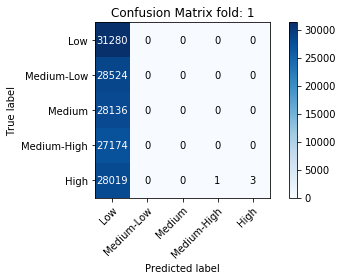

ACCURACY FOLD OBTAIN:     0.218553
PRECISION LOW:            0.218538


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


PRECISION MEDIUM-LOW:         0.0
PRECISION MEDIUM:             0.0
PRECISION MEDIUM-HIGH:        0.0
PRECISION HIGH:               1.0
RECALL LOW:                   1.0
RECALL MEDIUM-LOW:            0.0
RECALL MEDIUM:                0.0
RECALL MEDIUM-HIGH:           0.0
RECALL HIGH:              0.000107
FOLD NUMBER:                    2


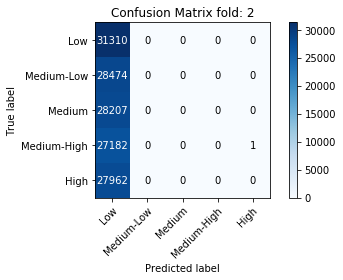

ACCURACY FOLD OBTAIN:     0.218743
PRECISION LOW:            0.218745
PRECISION MEDIUM-LOW:         0.0


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


PRECISION MEDIUM:             0.0
PRECISION MEDIUM-HIGH:        0.0
PRECISION HIGH:               0.0
RECALL LOW:                   1.0
RECALL MEDIUM-LOW:            0.0
RECALL MEDIUM:                0.0
RECALL MEDIUM-HIGH:           0.0
RECALL HIGH:                  0.0
FOLD NUMBER:                    3


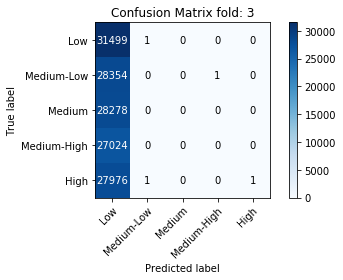

ACCURACY FOLD OBTAIN:     0.220072
PRECISION LOW:            0.220071
PRECISION MEDIUM-LOW:         0.0


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


PRECISION MEDIUM:             0.0
PRECISION MEDIUM-HIGH:        0.0
PRECISION HIGH:               1.0
RECALL LOW:               0.999968
RECALL MEDIUM-LOW:            0.0
RECALL MEDIUM:                0.0
RECALL MEDIUM-HIGH:           0.0
RECALL HIGH:              3.6e-05
ACCURACY OBTAIN:          0.219123

TRY OPTIMIERS:       RMSprop
TRY LEARNING RATE:   0.00467
TRY RHO:             0.6797
TRY NUMBER LAYERS:       2
TRY FIRST LAYER:       270
TRY SECOND LAYER:      207

RUN NUMBER:                     2
FOLD NUMBER:                    1


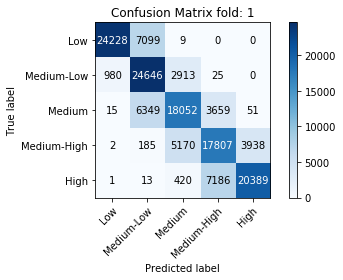

ACCURACY FOLD OBTAIN:     0.734415
PRECISION LOW:            0.960438
PRECISION MEDIUM-LOW:     0.643633
PRECISION MEDIUM:         0.679566
PRECISION MEDIUM-HIGH:    0.620951
PRECISION HIGH:           0.836369
RECALL LOW:               0.773168
RECALL MEDIUM-LOW:        0.862834
RECALL MEDIUM:            0.641826
RECALL MEDIUM-HIGH:       0.657036
RECALL HIGH:              0.727945
FOLD NUMBER:                    2


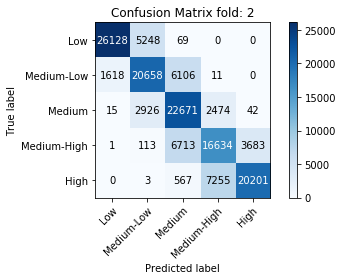

ACCURACY FOLD OBTAIN:     0.742594
PRECISION LOW:            0.941143
PRECISION MEDIUM-LOW:     0.713624
PRECISION MEDIUM:         0.627554
PRECISION MEDIUM-HIGH:    0.630697
PRECISION HIGH:           0.844312
RECALL LOW:               0.830911
RECALL MEDIUM-LOW:        0.727574
RECALL MEDIUM:            0.805994
RECALL MEDIUM-HIGH:       0.612806
RECALL HIGH:              0.720795
FOLD NUMBER:                    3


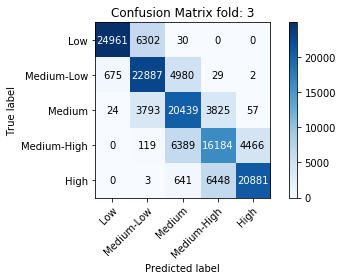

ACCURACY FOLD OBTAIN:     0.736032
PRECISION LOW:            0.972759
PRECISION MEDIUM-LOW:     0.691367
PRECISION MEDIUM:         0.629299
PRECISION MEDIUM-HIGH:    0.61104
PRECISION HIGH:           0.821892
RECALL LOW:               0.797654
RECALL MEDIUM-LOW:        0.801001
RECALL MEDIUM:            0.726384
RECALL MEDIUM-HIGH:       0.59592
RECALL HIGH:              0.74647
ACCURACY OBTAIN:          0.737681

TRY OPTIMIERS:       Adadelta
TRY LEARNING RATE:   0.03751
TRY RHO:             0.17471
TRY NUMBER LAYERS:       1
TRY FIRST LAYER:       165

RUN NUMBER:                     3
FOLD NUMBER:                    1


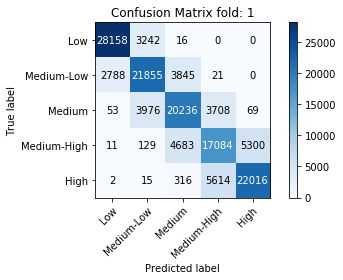

ACCURACY FOLD OBTAIN:     0.763946
PRECISION LOW:            0.907971
PRECISION MEDIUM-LOW:     0.748023
PRECISION MEDIUM:         0.695491
PRECISION MEDIUM-HIGH:    0.64646
PRECISION HIGH:           0.803944
RECALL LOW:               0.896295
RECALL MEDIUM-LOW:         0.7666
RECALL MEDIUM:            0.721632
RECALL MEDIUM-HIGH:       0.627927
RECALL HIGH:              0.787326
FOLD NUMBER:                    2


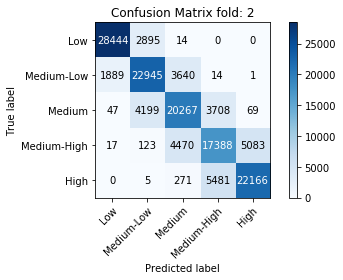

ACCURACY FOLD OBTAIN:     0.776953
PRECISION LOW:            0.93575
PRECISION MEDIUM-LOW:     0.760599
PRECISION MEDIUM:         0.707103
PRECISION MEDIUM-HIGH:    0.653905
PRECISION HIGH:           0.811377
RECALL LOW:               0.907218
RECALL MEDIUM-LOW:        0.805399
RECALL MEDIUM:            0.716402
RECALL MEDIUM-HIGH:       0.642074
RECALL HIGH:              0.793826
FOLD NUMBER:                    3


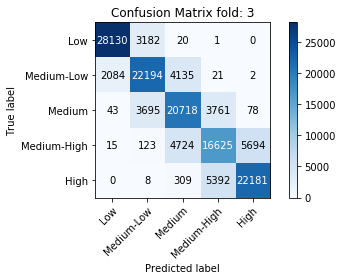

ACCURACY FOLD OBTAIN:     0.767443
PRECISION LOW:            0.929242
PRECISION MEDIUM-LOW:     0.760016
PRECISION MEDIUM:         0.692771
PRECISION MEDIUM-HIGH:    0.64438
PRECISION HIGH:           0.793454
RECALL LOW:               0.897776
RECALL MEDIUM-LOW:        0.78049
RECALL MEDIUM:            0.732214
RECALL MEDIUM-HIGH:       0.61164
RECALL HIGH:              0.795303
ACCURACY OBTAIN:          0.769448

TRY OPTIMIERS:       RMSprop
TRY LEARNING RATE:   0.08907
TRY RHO:             0.24347
TRY NUMBER LAYERS:       2
TRY FIRST LAYER:       273
TRY SECOND LAYER:      124

RUN NUMBER:                     4
FOLD NUMBER:                    1


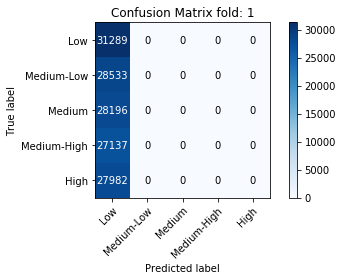

ACCURACY FOLD OBTAIN:     0.218595
PRECISION LOW:            0.218595


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


PRECISION MEDIUM-LOW:         0.0
PRECISION MEDIUM:             0.0
PRECISION MEDIUM-HIGH:        0.0
PRECISION HIGH:               0.0
RECALL LOW:                   1.0
RECALL MEDIUM-LOW:            0.0
RECALL MEDIUM:                0.0
RECALL MEDIUM-HIGH:           0.0
RECALL HIGH:                  0.0
FOLD NUMBER:                    2


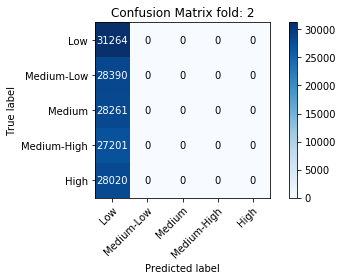

ACCURACY FOLD OBTAIN:     0.218422
PRECISION LOW:            0.218422


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


PRECISION MEDIUM-LOW:         0.0
PRECISION MEDIUM:             0.0
PRECISION MEDIUM-HIGH:        0.0
PRECISION HIGH:               0.0
RECALL LOW:                   1.0
RECALL MEDIUM-LOW:            0.0
RECALL MEDIUM:                0.0
RECALL MEDIUM-HIGH:           0.0
RECALL HIGH:                  0.0
FOLD NUMBER:                    3


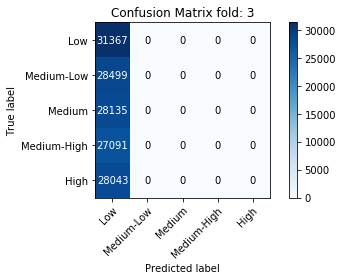

ACCURACY FOLD OBTAIN:     0.219143
PRECISION LOW:            0.219143


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


PRECISION MEDIUM-LOW:         0.0
PRECISION MEDIUM:             0.0
PRECISION MEDIUM-HIGH:        0.0
PRECISION HIGH:               0.0
RECALL LOW:                   1.0
RECALL MEDIUM-LOW:            0.0
RECALL MEDIUM:                0.0
RECALL MEDIUM-HIGH:           0.0
RECALL HIGH:                  0.0
ACCURACY OBTAIN:          0.21872

TRY OPTIMIERS:       Adadelta
TRY LEARNING RATE:   0.04621
TRY RHO:             0.46123
TRY NUMBER LAYERS:       1
TRY FIRST LAYER:       206

RUN NUMBER:                     5
FOLD NUMBER:                    1


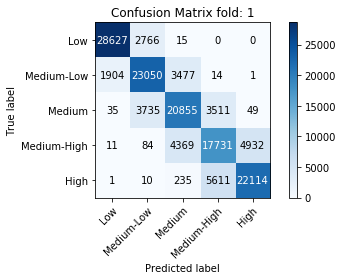

ACCURACY FOLD OBTAIN:     0.785101
PRECISION LOW:            0.936196
PRECISION MEDIUM-LOW:     0.777534
PRECISION MEDIUM:         0.720355
PRECISION MEDIUM-HIGH:    0.659955
PRECISION HIGH:           0.816135
RECALL LOW:               0.911456
RECALL MEDIUM-LOW:        0.810307
RECALL MEDIUM:            0.739933
RECALL MEDIUM-HIGH:       0.653629
RECALL HIGH:              0.790605
FOLD NUMBER:                    2


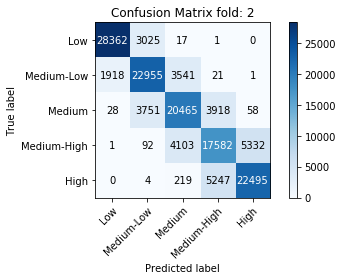

ACCURACY FOLD OBTAIN:     0.781488
PRECISION LOW:            0.935762
PRECISION MEDIUM-LOW:     0.769605
PRECISION MEDIUM:         0.721997
PRECISION MEDIUM-HIGH:    0.656805
PRECISION HIGH:           0.806677
RECALL LOW:               0.903105
RECALL MEDIUM-LOW:        0.807251
RECALL MEDIUM:            0.725195
RECALL MEDIUM-HIGH:       0.648543
RECALL HIGH:              0.804398
FOLD NUMBER:                    3


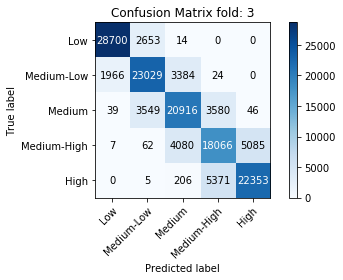

ACCURACY FOLD OBTAIN:     0.789912
PRECISION LOW:            0.934488
PRECISION MEDIUM-LOW:     0.786026
PRECISION MEDIUM:         0.731329
PRECISION MEDIUM-HIGH:    0.668097
PRECISION HIGH:           0.81331
RECALL LOW:               0.914974
RECALL MEDIUM-LOW:        0.810795
RECALL MEDIUM:            0.743548
RECALL MEDIUM-HIGH:       0.661758
RECALL HIGH:              0.800179
ACCURACY OBTAIN:           0.7855



/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [32]:
bo = GPGO(sur_model, acq, compute_accuracy, param, n_jobs=1)
best_seen = list()
run = 1
bo._firstRun(5)

TRY OPTIMIERS:       Adadelta
TRY LEARNING RATE:   0.07571
TRY RHO:             0.29731
TRY NUMBER LAYERS:       1
TRY FIRST LAYER:       171

RUN NUMBER:                     6
FOLD NUMBER:                    1


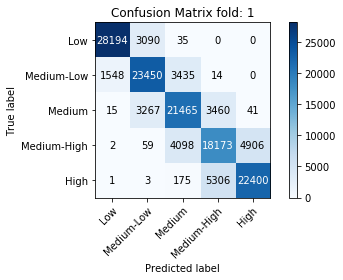

ACCURACY FOLD OBTAIN:     0.794218
PRECISION LOW:            0.947379
PRECISION MEDIUM-LOW:     0.785095
PRECISION MEDIUM:         0.734901
PRECISION MEDIUM-HIGH:    0.674248
PRECISION HIGH:           0.819103
RECALL LOW:               0.90022
RECALL MEDIUM-LOW:        0.82434
RECALL MEDIUM:            0.759877
RECALL MEDIUM-HIGH:       0.667193
RECALL HIGH:              0.803299
FOLD NUMBER:                    2


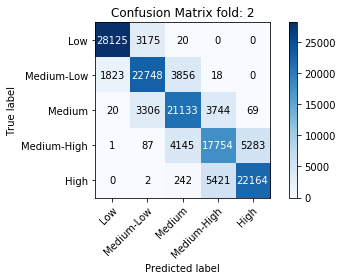

ACCURACY FOLD OBTAIN:     0.781942
PRECISION LOW:            0.93847
PRECISION MEDIUM-LOW:     0.775906
PRECISION MEDIUM:         0.718907
PRECISION MEDIUM-HIGH:    0.659093
PRECISION HIGH:           0.805495
RECALL LOW:               0.897989
RECALL MEDIUM-LOW:        0.799719
RECALL MEDIUM:            0.747489
RECALL MEDIUM-HIGH:       0.651045
RECALL HIGH:              0.796435
FOLD NUMBER:                    3


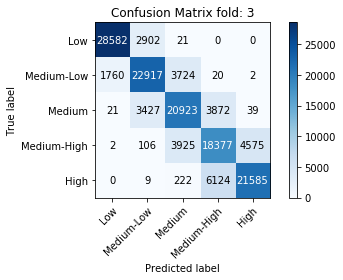

ACCURACY FOLD OBTAIN:     0.785161
PRECISION LOW:            0.941281
PRECISION MEDIUM-LOW:     0.780525
PRECISION MEDIUM:         0.726115
PRECISION MEDIUM-HIGH:    0.647237
PRECISION HIGH:           0.823824
RECALL LOW:               0.907221
RECALL MEDIUM-LOW:        0.806284
RECALL MEDIUM:            0.739799
RECALL MEDIUM-HIGH:       0.681008
RECALL HIGH:              0.772548
ACCURACY OBTAIN:          0.787107

init   	 [7.57127093e-02 8.58529789e-01 2.97314662e-01 1.00000000e+00
 1.71000000e+02 1.69000000e+02 7.70000000e+01 3.00000000e+00]. 	  0.7871068716049194 	 0.7871068716049194


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adadelta
TRY LEARNING RATE:   0.09428
TRY RHO:             0.92256
TRY NUMBER LAYERS:       1
TRY FIRST LAYER:       150

RUN NUMBER:                     7
FOLD NUMBER:                    1


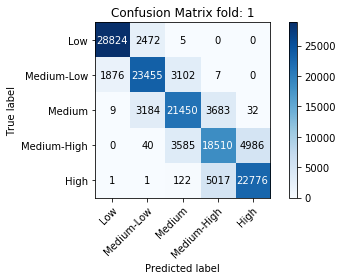

ACCURACY FOLD OBTAIN:     0.803531
PRECISION LOW:            0.938587
PRECISION MEDIUM-LOW:     0.804576
PRECISION MEDIUM:         0.758916
PRECISION MEDIUM-HIGH:    0.68009
PRECISION HIGH:           0.819457
RECALL LOW:               0.920865
RECALL MEDIUM-LOW:        0.824719
RECALL MEDIUM:             0.7564
RECALL MEDIUM-HIGH:       0.682497
RECALL HIGH:              0.815847
FOLD NUMBER:                    2


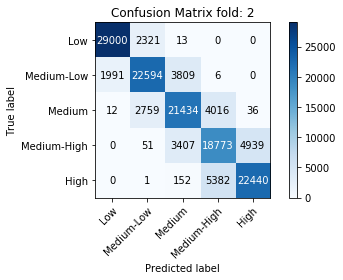

ACCURACY FOLD OBTAIN:     0.798129
PRECISION LOW:            0.935393
PRECISION MEDIUM-LOW:     0.814903
PRECISION MEDIUM:         0.743849
PRECISION MEDIUM-HIGH:    0.666253
PRECISION HIGH:           0.81853
RECALL LOW:               0.925512
RECALL MEDIUM-LOW:        0.795563
RECALL MEDIUM:            0.758538
RECALL MEDIUM-HIGH:       0.690946
RECALL HIGH:              0.802145
FOLD NUMBER:                    3


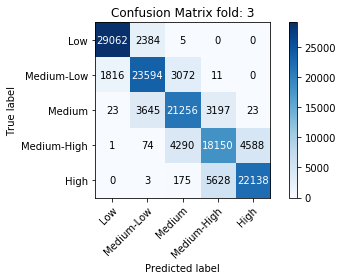

ACCURACY FOLD OBTAIN:     0.797848
PRECISION LOW:            0.940457
PRECISION MEDIUM-LOW:     0.794411
PRECISION MEDIUM:         0.738107
PRECISION MEDIUM-HIGH:    0.672571
PRECISION HIGH:           0.82762
RECALL LOW:               0.924041
RECALL MEDIUM-LOW:        0.828063
RECALL MEDIUM:            0.755259
RECALL MEDIUM-HIGH:       0.669668
RECALL HIGH:              0.792227
ACCURACY OBTAIN:          0.799836

1      	 [9.42801935e-02 4.38908155e-01 9.22557629e-01 1.00000000e+00
 1.50000000e+02 1.58000000e+02 7.00000000e+01 3.00000000e+00]. 	  0.7998360395431519 	 0.7998360395431519


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adadelta
TRY LEARNING RATE:   0.09689
TRY RHO:             0.53495
TRY NUMBER LAYERS:       2
TRY FIRST LAYER:       237
TRY SECOND LAYER:      232

RUN NUMBER:                     8
FOLD NUMBER:                    1


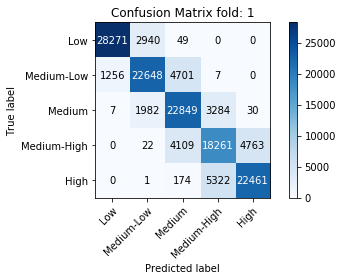

ACCURACY FOLD OBTAIN:     0.799863
PRECISION LOW:            0.957236
PRECISION MEDIUM-LOW:     0.820788
PRECISION MEDIUM:         0.716674
PRECISION MEDIUM-HIGH:    0.679504
PRECISION HIGH:           0.824136
RECALL LOW:               0.904383
RECALL MEDIUM-LOW:        0.791556
RECALL MEDIUM:            0.81163
RECALL MEDIUM-HIGH:       0.672473
RECALL HIGH:              0.803384
FOLD NUMBER:                    2


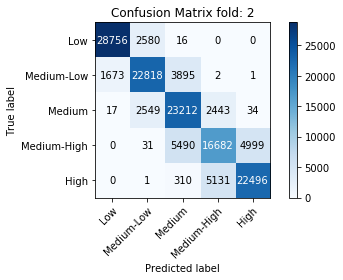

ACCURACY FOLD OBTAIN:     0.796194
PRECISION LOW:            0.944492
PRECISION MEDIUM-LOW:     0.81554
PRECISION MEDIUM:         0.705039
PRECISION MEDIUM-HIGH:    0.687691
PRECISION HIGH:           0.817145
RECALL LOW:               0.917198
RECALL MEDIUM-LOW:        0.803762
RECALL MEDIUM:            0.821518
RECALL MEDIUM-HIGH:       0.613264
RECALL HIGH:              0.805212
FOLD NUMBER:                    3


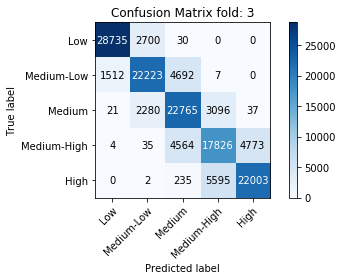

ACCURACY FOLD OBTAIN:     0.793321
PRECISION LOW:            0.949227
PRECISION MEDIUM-LOW:     0.815822
PRECISION MEDIUM:         0.705104
PRECISION MEDIUM-HIGH:    0.672071
PRECISION HIGH:           0.820609
RECALL LOW:               0.913237
RECALL MEDIUM-LOW:        0.781564
RECALL MEDIUM:            0.807298
RECALL MEDIUM-HIGH:       0.655319
RECALL HIGH:              0.79048
ACCURACY OBTAIN:          0.796459

2      	 [9.68926654e-02 1.54225342e-01 5.34947636e-01 2.00000000e+00
 2.37000000e+02 2.32000000e+02 8.10000000e+01 3.00000000e+00]. 	  0.7964592973391215 	 0.7998360395431519


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adadelta
TRY LEARNING RATE:   0.01949
TRY RHO:             0.79578
TRY NUMBER LAYERS:       1
TRY FIRST LAYER:       187

RUN NUMBER:                     9
FOLD NUMBER:                    1


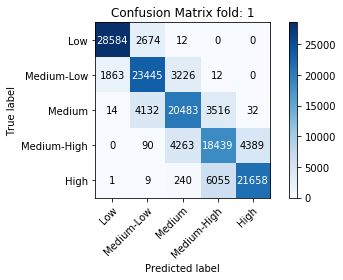

ACCURACY FOLD OBTAIN:     0.786722
PRECISION LOW:            0.938349
PRECISION MEDIUM-LOW:     0.772488
PRECISION MEDIUM:         0.72573
PRECISION MEDIUM-HIGH:    0.658019
PRECISION HIGH:           0.830477
RECALL LOW:               0.914103
RECALL MEDIUM-LOW:        0.821306
RECALL MEDIUM:            0.72694
RECALL MEDIUM-HIGH:       0.678378
RECALL HIGH:              0.774523
FOLD NUMBER:                    2


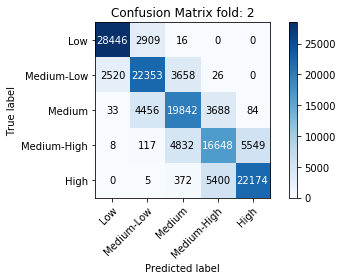

ACCURACY FOLD OBTAIN:     0.764748
PRECISION LOW:            0.917406
PRECISION MEDIUM-LOW:     0.749095
PRECISION MEDIUM:         0.690877
PRECISION MEDIUM-HIGH:    0.646223
PRECISION HIGH:           0.797425
RECALL LOW:               0.906761
RECALL MEDIUM-LOW:        0.78275
RECALL MEDIUM:            0.706046
RECALL MEDIUM-HIGH:       0.613096
RECALL HIGH:              0.793317
FOLD NUMBER:                    3


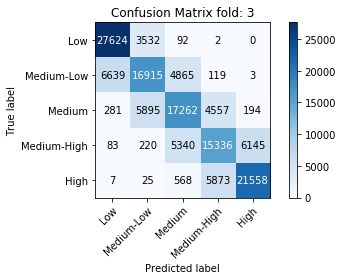

ACCURACY FOLD OBTAIN:     0.689524
PRECISION LOW:            0.797598
PRECISION MEDIUM-LOW:     0.636213
PRECISION MEDIUM:         0.613716
PRECISION MEDIUM-HIGH:    0.592421
PRECISION HIGH:           0.772688
RECALL LOW:               0.883968
RECALL MEDIUM-LOW:        0.592656
RECALL MEDIUM:            0.612367
RECALL MEDIUM-HIGH:       0.565403
RECALL HIGH:              0.769077
ACCURACY OBTAIN:          0.746998

3      	 [1.94874270e-02 7.03258144e-01 7.95775453e-01 1.00000000e+00
 1.87000000e+02 2.25000000e+02 7.30000000e+01 3.00000000e+00]. 	  0.7469979723294576 	 0.7998360395431519


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adadelta
TRY LEARNING RATE:   0.08708
TRY RHO:             0.80576
TRY NUMBER LAYERS:       1
TRY FIRST LAYER:       220

RUN NUMBER:                    10
FOLD NUMBER:                    1


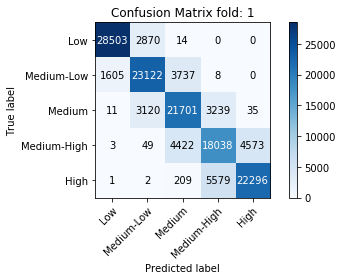

ACCURACY FOLD OBTAIN:     0.794064
PRECISION LOW:            0.94622
PRECISION MEDIUM-LOW:     0.792854
PRECISION MEDIUM:         0.721371
PRECISION MEDIUM-HIGH:    0.671456
PRECISION HIGH:           0.828724
RECALL LOW:               0.908115
RECALL MEDIUM-LOW:        0.812096
RECALL MEDIUM:            0.772113
RECALL MEDIUM-HIGH:       0.665977
RECALL HIGH:              0.793819
FOLD NUMBER:                    2


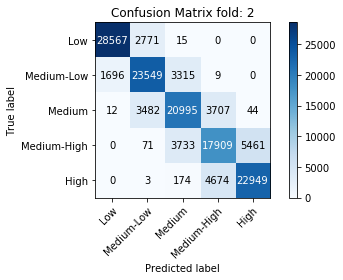

ACCURACY FOLD OBTAIN:     0.796229
PRECISION LOW:            0.943584
PRECISION MEDIUM-LOW:     0.788225
PRECISION MEDIUM:         0.74366
PRECISION MEDIUM-HIGH:    0.680976
PRECISION HIGH:           0.80653
RECALL LOW:               0.911141
RECALL MEDIUM-LOW:        0.824285
RECALL MEDIUM:            0.743449
RECALL MEDIUM-HIGH:       0.659049
RECALL HIGH:              0.825504
FOLD NUMBER:                    3


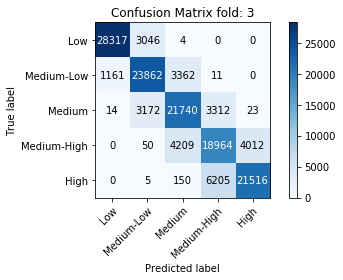

ACCURACY FOLD OBTAIN:     0.799239
PRECISION LOW:            0.960159
PRECISION MEDIUM-LOW:     0.791837
PRECISION MEDIUM:         0.737825
PRECISION MEDIUM-HIGH:    0.66559
PRECISION HIGH:           0.842081
RECALL LOW:               0.902764
RECALL MEDIUM-LOW:        0.84033
RECALL MEDIUM:            0.769258
RECALL MEDIUM-HIGH:       0.69631
RECALL HIGH:              0.771847
ACCURACY OBTAIN:          0.796511

4      	 [8.70806079e-02 6.98424497e-01 8.05755431e-01 1.00000000e+00
 2.20000000e+02 1.57000000e+02 7.10000000e+01 3.00000000e+00]. 	  0.7965105573336283 	 0.7998360395431519


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adadelta
TRY LEARNING RATE:   0.04009
TRY RHO:             0.72185
TRY NUMBER LAYERS:       1
TRY FIRST LAYER:       156

RUN NUMBER:                    11
FOLD NUMBER:                    1


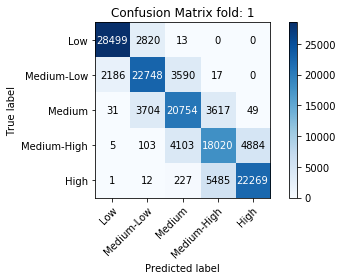

ACCURACY FOLD OBTAIN:     0.784493
PRECISION LOW:            0.927641
PRECISION MEDIUM-LOW:     0.774084
PRECISION MEDIUM:         0.723464
PRECISION MEDIUM-HIGH:    0.663989
PRECISION HIGH:           0.818653
RECALL LOW:               0.909581
RECALL MEDIUM-LOW:        0.797029
RECALL MEDIUM:            0.737134
RECALL MEDIUM-HIGH:       0.664577
RECALL HIGH:              0.795492
FOLD NUMBER:                    2


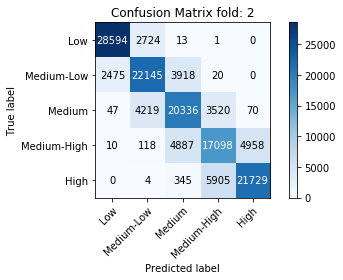

ACCURACY FOLD OBTAIN:     0.767815
PRECISION LOW:            0.918653
PRECISION MEDIUM-LOW:     0.758131
PRECISION MEDIUM:         0.689379
PRECISION MEDIUM-HIGH:    0.644138
PRECISION HIGH:           0.812087
RECALL LOW:               0.912613
RECALL MEDIUM-LOW:        0.775439
RECALL MEDIUM:            0.721339
RECALL MEDIUM-HIGH:       0.631598
RECALL HIGH:              0.776507
FOLD NUMBER:                    3


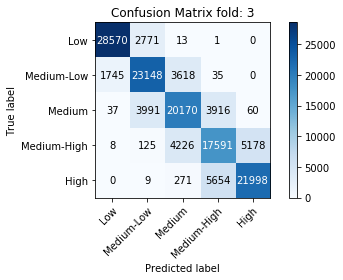

ACCURACY FOLD OBTAIN:     0.778824
PRECISION LOW:            0.941041
PRECISION MEDIUM-LOW:     0.77047
PRECISION MEDIUM:         0.712771
PRECISION MEDIUM-HIGH:    0.646799
PRECISION HIGH:           0.807681
RECALL LOW:               0.911178
RECALL MEDIUM-LOW:        0.810902
RECALL MEDIUM:            0.715908
RECALL MEDIUM-HIGH:       0.648444
RECALL HIGH:              0.787555
ACCURACY OBTAIN:          0.777044

5      	 [4.00853173e-02 5.26458396e-01 7.21849911e-01 1.00000000e+00
 1.56000000e+02 1.57000000e+02 7.10000000e+01 3.00000000e+00]. 	  0.7770441969235738 	 0.7998360395431519


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adadelta
TRY LEARNING RATE:   0.08333
TRY RHO:             0.91239
TRY NUMBER LAYERS:       1
TRY FIRST LAYER:       182

RUN NUMBER:                    12
FOLD NUMBER:                    1


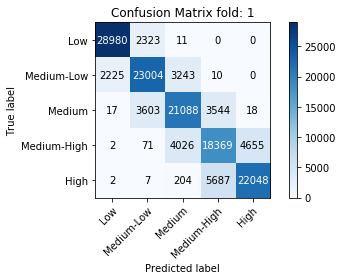

ACCURACY FOLD OBTAIN:     0.79287
PRECISION LOW:            0.928073
PRECISION MEDIUM-LOW:     0.793023
PRECISION MEDIUM:         0.738065
PRECISION MEDIUM-HIGH:    0.665302
PRECISION HIGH:           0.825119
RECALL LOW:               0.925465
RECALL MEDIUM-LOW:        0.807668
RECALL MEDIUM:            0.74595
RECALL MEDIUM-HIGH:       0.677248
RECALL HIGH:              0.788894
FOLD NUMBER:                    2


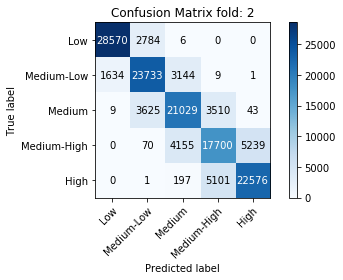

ACCURACY FOLD OBTAIN:     0.793707
PRECISION LOW:            0.945619
PRECISION MEDIUM-LOW:     0.785523
PRECISION MEDIUM:         0.737058
PRECISION MEDIUM-HIGH:    0.672492
PRECISION HIGH:           0.810366
RECALL LOW:               0.911033
RECALL MEDIUM-LOW:        0.832124
RECALL MEDIUM:            0.745286
RECALL MEDIUM-HIGH:       0.651598
RECALL HIGH:              0.809901
FOLD NUMBER:                    3


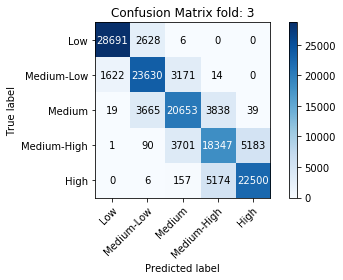

ACCURACY FOLD OBTAIN:     0.7952
PRECISION LOW:            0.945868
PRECISION MEDIUM-LOW:     0.787168
PRECISION MEDIUM:         0.745919
PRECISION MEDIUM-HIGH:    0.670259
PRECISION HIGH:           0.81163
RECALL LOW:               0.915914
RECALL MEDIUM-LOW:        0.83096
RECALL MEDIUM:            0.732012
RECALL MEDIUM-HIGH:       0.67151
RECALL HIGH:              0.808277
ACCURACY OBTAIN:          0.793926

6      	 [8.33310717e-02 8.35757166e-01 9.12388056e-01 1.00000000e+00
 1.82000000e+02 1.36000000e+02 6.30000000e+01 3.00000000e+00]. 	  0.7939255833625793 	 0.7998360395431519


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:         SGD
TRY LEARNING RATE:   0.01622
TRY MOMENTUM:        0.55129
TRY NUMBER LAYERS:       2
TRY FIRST LAYER:       241
TRY SECOND LAYER:      227

RUN NUMBER:                    13
FOLD NUMBER:                    1


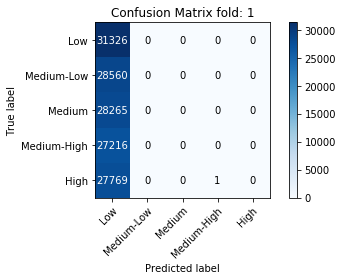

ACCURACY FOLD OBTAIN:     0.218853
PRECISION LOW:            0.218855


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


PRECISION MEDIUM-LOW:         0.0
PRECISION MEDIUM:             0.0
PRECISION MEDIUM-HIGH:        0.0
PRECISION HIGH:               0.0
RECALL LOW:                   1.0
RECALL MEDIUM-LOW:            0.0
RECALL MEDIUM:                0.0
RECALL MEDIUM-HIGH:           0.0
RECALL HIGH:                  0.0
FOLD NUMBER:                    2


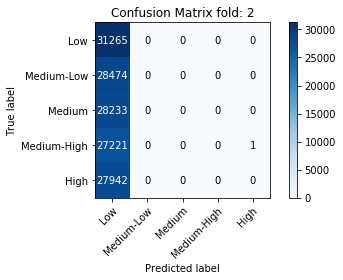

ACCURACY FOLD OBTAIN:     0.218429
PRECISION LOW:            0.21843


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


PRECISION MEDIUM-LOW:         0.0
PRECISION MEDIUM:             0.0
PRECISION MEDIUM-HIGH:        0.0
PRECISION HIGH:               0.0
RECALL LOW:                   1.0
RECALL MEDIUM-LOW:            0.0
RECALL MEDIUM:                0.0
RECALL MEDIUM-HIGH:           0.0
RECALL HIGH:                  0.0
FOLD NUMBER:                    3


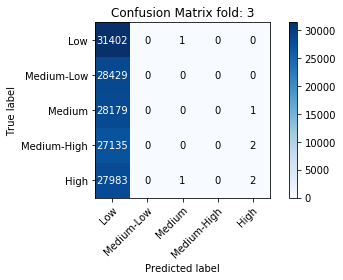

ACCURACY FOLD OBTAIN:     0.219401
PRECISION LOW:            0.219398
PRECISION MEDIUM-LOW:         0.0


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


PRECISION MEDIUM:             0.0
PRECISION MEDIUM-HIGH:        0.0
PRECISION HIGH:               0.4
RECALL LOW:               0.999968
RECALL MEDIUM-LOW:            0.0
RECALL MEDIUM:                0.0
RECALL MEDIUM-HIGH:           0.0
RECALL HIGH:              7.1e-05
ACCURACY OBTAIN:          0.218894

7      	 [1.62178558e-02 5.51294042e-01 1.69501790e-01 2.00000000e+00
 2.41000000e+02 2.27000000e+02 7.30000000e+01 0.00000000e+00]. 	  0.21889438728491464 	 0.7998360395431519


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:         SGD
TRY LEARNING RATE:   0.08789
TRY MOMENTUM:        0.51861
TRY NUMBER LAYERS:       1
TRY FIRST LAYER:       232

RUN NUMBER:                    14
FOLD NUMBER:                    1


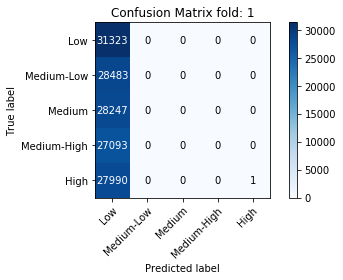

ACCURACY FOLD OBTAIN:     0.218839
PRECISION LOW:            0.218834


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


PRECISION MEDIUM-LOW:         0.0
PRECISION MEDIUM:             0.0
PRECISION MEDIUM-HIGH:        0.0
PRECISION HIGH:               1.0
RECALL LOW:                   1.0
RECALL MEDIUM-LOW:            0.0
RECALL MEDIUM:                0.0
RECALL MEDIUM-HIGH:           0.0
RECALL HIGH:              3.6e-05
FOLD NUMBER:                    2


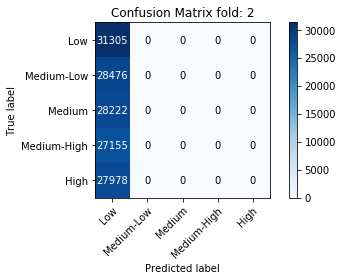

ACCURACY FOLD OBTAIN:     0.218708
PRECISION LOW:            0.218708


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


PRECISION MEDIUM-LOW:         0.0
PRECISION MEDIUM:             0.0
PRECISION MEDIUM-HIGH:        0.0
PRECISION HIGH:               0.0
RECALL LOW:                   1.0
RECALL MEDIUM-LOW:            0.0
RECALL MEDIUM:                0.0
RECALL MEDIUM-HIGH:           0.0
RECALL HIGH:                  0.0
FOLD NUMBER:                    3


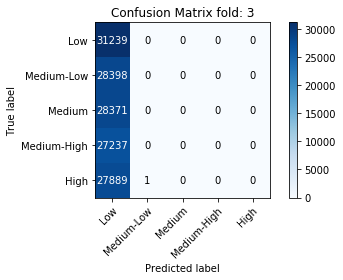

ACCURACY FOLD OBTAIN:     0.218249
PRECISION LOW:            0.21825
PRECISION MEDIUM-LOW:         0.0


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


PRECISION MEDIUM:             0.0
PRECISION MEDIUM-HIGH:        0.0
PRECISION HIGH:               0.0
RECALL LOW:                   1.0
RECALL MEDIUM-LOW:            0.0
RECALL MEDIUM:                0.0
RECALL MEDIUM-HIGH:           0.0
RECALL HIGH:                  0.0
ACCURACY OBTAIN:          0.218599

8      	 [8.78932037e-02 5.18607694e-01 9.12408451e-01 1.00000000e+00
 2.32000000e+02 2.00000000e+02 9.90000000e+01 0.00000000e+00]. 	  0.21859862407048544 	 0.7998360395431519


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:         SGD
TRY LEARNING RATE:   0.09398
TRY MOMENTUM:        0.25935
TRY NUMBER LAYERS:       2
TRY FIRST LAYER:       229
TRY SECOND LAYER:      235

RUN NUMBER:                    15
FOLD NUMBER:                    1


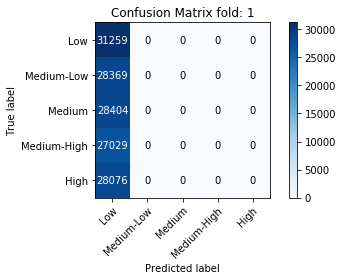

ACCURACY FOLD OBTAIN:     0.218385
PRECISION LOW:            0.218385


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


PRECISION MEDIUM-LOW:         0.0
PRECISION MEDIUM:             0.0
PRECISION MEDIUM-HIGH:        0.0
PRECISION HIGH:               0.0
RECALL LOW:                   1.0
RECALL MEDIUM-LOW:            0.0
RECALL MEDIUM:                0.0
RECALL MEDIUM-HIGH:           0.0
RECALL HIGH:                  0.0
FOLD NUMBER:                    2


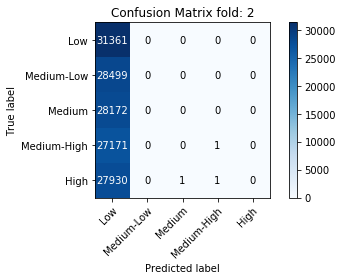

ACCURACY FOLD OBTAIN:     0.219106
PRECISION LOW:            0.219104
PRECISION MEDIUM-LOW:         0.0


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


PRECISION MEDIUM:             0.0
PRECISION MEDIUM-HIGH:        0.5
PRECISION HIGH:               0.0
RECALL LOW:                   1.0
RECALL MEDIUM-LOW:            0.0
RECALL MEDIUM:                0.0
RECALL MEDIUM-HIGH:       3.7e-05
RECALL HIGH:                  0.0
FOLD NUMBER:                    3


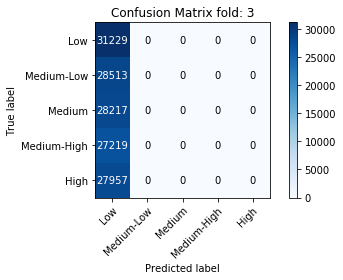

ACCURACY FOLD OBTAIN:     0.218179
PRECISION LOW:            0.218179
PRECISION MEDIUM-LOW:         0.0


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


PRECISION MEDIUM:             0.0
PRECISION MEDIUM-HIGH:        0.0
PRECISION HIGH:               0.0
RECALL LOW:                   1.0
RECALL MEDIUM-LOW:            0.0
RECALL MEDIUM:                0.0
RECALL MEDIUM-HIGH:           0.0
RECALL HIGH:                  0.0
ACCURACY OBTAIN:          0.218557

9      	 [9.39815553e-02 2.59354591e-01 4.04892848e-01 2.00000000e+00
 2.29000000e+02 2.35000000e+02 5.60000000e+01 0.00000000e+00]. 	  0.21855671207110086 	 0.7998360395431519


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adagrad
TRY LEARNING RATE:   0.09269
TRY NUMBER LAYERS:       1
TRY FIRST LAYER:       245

RUN NUMBER:                    16
FOLD NUMBER:                    1


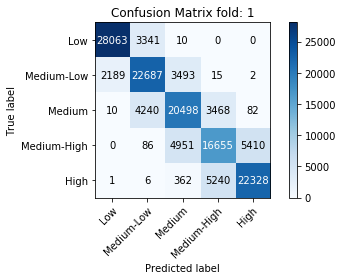

ACCURACY FOLD OBTAIN:     0.770108
PRECISION LOW:            0.927304
PRECISION MEDIUM-LOW:     0.747266
PRECISION MEDIUM:         0.699256
PRECISION MEDIUM-HIGH:    0.656277
PRECISION HIGH:           0.80253
RECALL LOW:               0.893328
RECALL MEDIUM-LOW:        0.799232
RECALL MEDIUM:            0.724362
RECALL MEDIUM-HIGH:       0.61453
RECALL HIGH:              0.799227
FOLD NUMBER:                    2


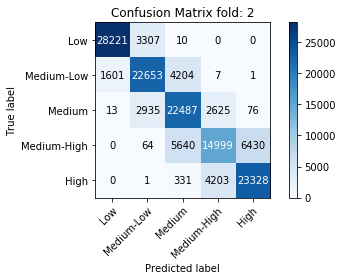

ACCURACY FOLD OBTAIN:     0.780293
PRECISION LOW:            0.945902
PRECISION MEDIUM-LOW:     0.782217
PRECISION MEDIUM:         0.688265
PRECISION MEDIUM-HIGH:    0.686956
PRECISION HIGH:            0.7819
RECALL LOW:               0.894825
RECALL MEDIUM-LOW:        0.795791
RECALL MEDIUM:            0.799225
RECALL MEDIUM-HIGH:       0.552795
RECALL HIGH:              0.837239
FOLD NUMBER:                    3


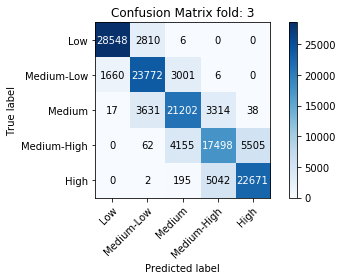

ACCURACY FOLD OBTAIN:     0.794292
PRECISION LOW:            0.944516
PRECISION MEDIUM-LOW:     0.78515
PRECISION MEDIUM:         0.742393
PRECISION MEDIUM-HIGH:    0.676643
PRECISION HIGH:           0.803537
RECALL LOW:               0.910216
RECALL MEDIUM-LOW:        0.835894
RECALL MEDIUM:            0.751791
RECALL MEDIUM-HIGH:       0.642836
RECALL HIGH:              0.81229
ACCURACY OBTAIN:          0.781564

10     	 [9.26858711e-02 3.19685911e-01 8.27561100e-01 1.00000000e+00
 2.45000000e+02 1.33000000e+02 6.30000000e+01 2.00000000e+00]. 	  0.7815644343694051 	 0.7998360395431519


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adagrad
TRY LEARNING RATE:   0.08276
TRY NUMBER LAYERS:       1
TRY FIRST LAYER:       253

RUN NUMBER:                    17
FOLD NUMBER:                    1


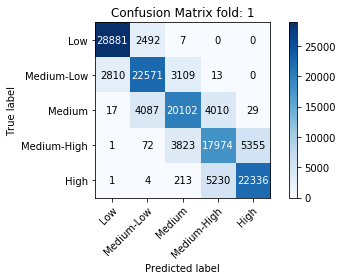

ACCURACY FOLD OBTAIN:     0.781517
PRECISION LOW:            0.910785
PRECISION MEDIUM-LOW:     0.772292
PRECISION MEDIUM:         0.73758
PRECISION MEDIUM-HIGH:    0.660154
PRECISION HIGH:           0.805772
RECALL LOW:               0.920363
RECALL MEDIUM-LOW:        0.791882
RECALL MEDIUM:            0.711701
RECALL MEDIUM-HIGH:       0.660202
RECALL HIGH:              0.803916
FOLD NUMBER:                    2


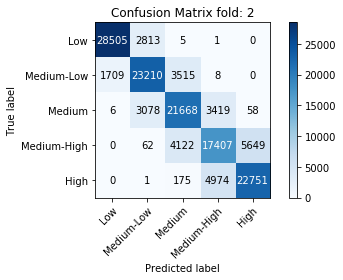

ACCURACY FOLD OBTAIN:     0.793239
PRECISION LOW:            0.94325
PRECISION MEDIUM-LOW:     0.795844
PRECISION MEDIUM:         0.734882
PRECISION MEDIUM-HIGH:    0.674455
PRECISION HIGH:           0.799459
RECALL LOW:               0.910005
RECALL MEDIUM-LOW:        0.816047
RECALL MEDIUM:            0.767579
RECALL MEDIUM-HIGH:       0.639023
RECALL HIGH:              0.815419
FOLD NUMBER:                    3


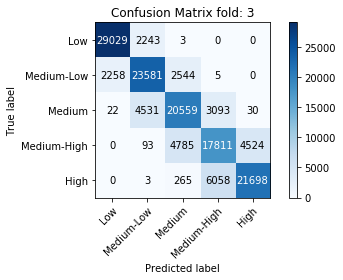

ACCURACY FOLD OBTAIN:     0.787215
PRECISION LOW:            0.927177
PRECISION MEDIUM-LOW:     0.774392
PRECISION MEDIUM:         0.730182
PRECISION MEDIUM-HIGH:    0.660474
PRECISION HIGH:           0.826528
RECALL LOW:               0.928185
RECALL MEDIUM-LOW:        0.830668
RECALL MEDIUM:            0.728139
RECALL MEDIUM-HIGH:       0.654503
RECALL HIGH:              0.774265
ACCURACY OBTAIN:          0.787323

11     	 [8.27589784e-02 6.25245166e-01 8.21282231e-01 1.00000000e+00
 2.53000000e+02 2.30000000e+02 9.10000000e+01 2.00000000e+00]. 	  0.7873234947522482 	 0.7998360395431519


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adadelta
TRY LEARNING RATE:   0.09883
TRY RHO:             0.35407
TRY NUMBER LAYERS:       2
TRY FIRST LAYER:       235
TRY SECOND LAYER:      216

RUN NUMBER:                    18
FOLD NUMBER:                    1


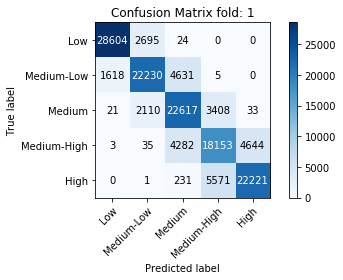

ACCURACY FOLD OBTAIN:     0.795217
PRECISION LOW:            0.945712
PRECISION MEDIUM-LOW:     0.821174
PRECISION MEDIUM:         0.711562
PRECISION MEDIUM-HIGH:    0.668939
PRECISION HIGH:           0.826121
RECALL LOW:               0.913195
RECALL MEDIUM-LOW:        0.780438
RECALL MEDIUM:            0.802334
RECALL MEDIUM-HIGH:       0.669432
RECALL HIGH:              0.792927
FOLD NUMBER:                    2


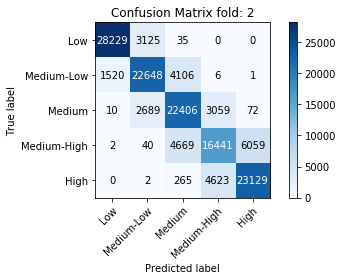

ACCURACY FOLD OBTAIN:     0.788432
PRECISION LOW:            0.948523
PRECISION MEDIUM-LOW:     0.794555
PRECISION MEDIUM:         0.711731
PRECISION MEDIUM-HIGH:    0.681379
PRECISION HIGH:           0.790438
RECALL LOW:               0.899328
RECALL MEDIUM-LOW:        0.80082
RECALL MEDIUM:            0.793526
RECALL MEDIUM-HIGH:       0.604204
RECALL HIGH:              0.825476
FOLD NUMBER:                    3


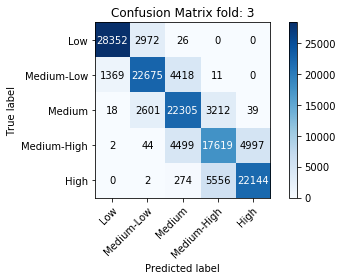

ACCURACY FOLD OBTAIN:     0.790128
PRECISION LOW:            0.953297
PRECISION MEDIUM-LOW:     0.801407
PRECISION MEDIUM:         0.707601
PRECISION MEDIUM-HIGH:    0.667437
PRECISION HIGH:           0.814717
RECALL LOW:               0.90437
RECALL MEDIUM-LOW:        0.796368
RECALL MEDIUM:            0.791659
RECALL MEDIUM-HIGH:       0.648687
RECALL HIGH:              0.791536
ACCURACY OBTAIN:          0.791259

12     	 [9.88330705e-02 8.38565949e-01 3.54069475e-01 2.00000000e+00
 2.35000000e+02 2.16000000e+02 5.10000000e+01 3.00000000e+00]. 	  0.7912591099739075 	 0.7998360395431519


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adadelta
TRY LEARNING RATE:   0.01606
TRY RHO:             0.57287
TRY NUMBER LAYERS:       1
TRY FIRST LAYER:       283

RUN NUMBER:                    19
FOLD NUMBER:                    1


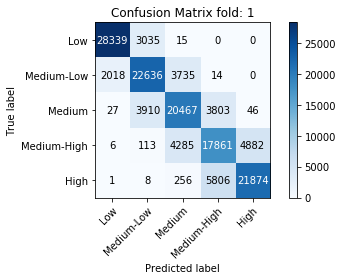

ACCURACY FOLD OBTAIN:     0.776717
PRECISION LOW:            0.93248
PRECISION MEDIUM-LOW:     0.762104
PRECISION MEDIUM:         0.711698
PRECISION MEDIUM-HIGH:    0.649869
PRECISION HIGH:           0.816133
RECALL LOW:               0.902832
RECALL MEDIUM-LOW:        0.796958
RECALL MEDIUM:            0.724419
RECALL MEDIUM-HIGH:       0.657936
RECALL HIGH:              0.782752
FOLD NUMBER:                    2


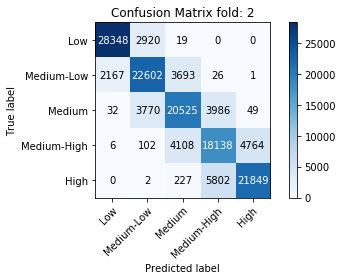

ACCURACY FOLD OBTAIN:     0.778714
PRECISION LOW:            0.92783
PRECISION MEDIUM-LOW:     0.76888
PRECISION MEDIUM:         0.718361
PRECISION MEDIUM-HIGH:    0.648898
PRECISION HIGH:           0.81945
RECALL LOW:               0.906063
RECALL MEDIUM-LOW:        0.793359
RECALL MEDIUM:            0.72368
RECALL MEDIUM-HIGH:       0.668855
RECALL HIGH:              0.78368
FOLD NUMBER:                    3


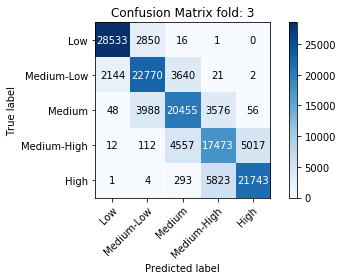

ACCURACY FOLD OBTAIN:     0.77531
PRECISION LOW:            0.928265
PRECISION MEDIUM-LOW:     0.766048
PRECISION MEDIUM:         0.706295
PRECISION MEDIUM-HIGH:    0.649699
PRECISION HIGH:           0.810761
RECALL LOW:               0.908694
RECALL MEDIUM-LOW:        0.796795
RECALL MEDIUM:            0.727341
RECALL MEDIUM-HIGH:       0.643075
RECALL HIGH:              0.780326
ACCURACY OBTAIN:          0.776914

13     	 [1.60593977e-02 6.70465356e-01 5.72868179e-01 1.00000000e+00
 2.83000000e+02 1.14000000e+02 6.30000000e+01 3.00000000e+00]. 	  0.7769138018290201 	 0.7998360395431519


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adadelta
TRY LEARNING RATE:   0.09644
TRY RHO:             0.88094
TRY NUMBER LAYERS:       1
TRY FIRST LAYER:       228

RUN NUMBER:                    20
FOLD NUMBER:                    1


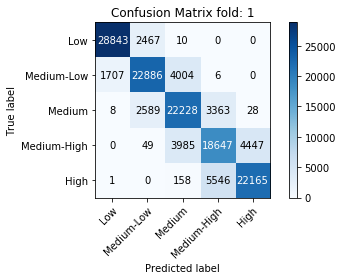

ACCURACY FOLD OBTAIN:     0.801812
PRECISION LOW:            0.943846
PRECISION MEDIUM-LOW:     0.81762
PRECISION MEDIUM:         0.731545
PRECISION MEDIUM-HIGH:    0.676547
PRECISION HIGH:           0.83202
RECALL LOW:               0.920913
RECALL MEDIUM-LOW:        0.800126
RECALL MEDIUM:            0.78778
RECALL MEDIUM-HIGH:       0.687371
RECALL HIGH:               0.7953
FOLD NUMBER:                    2


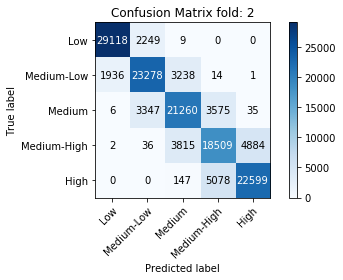

ACCURACY FOLD OBTAIN:     0.801783
PRECISION LOW:            0.937415
PRECISION MEDIUM-LOW:     0.805189
PRECISION MEDIUM:         0.746777
PRECISION MEDIUM-HIGH:    0.681079
PRECISION HIGH:           0.821214
RECALL LOW:               0.928034
RECALL MEDIUM-LOW:        0.817719
RECALL MEDIUM:            0.753286
RECALL MEDIUM-HIGH:       0.679329
RECALL HIGH:              0.812212
FOLD NUMBER:                    3


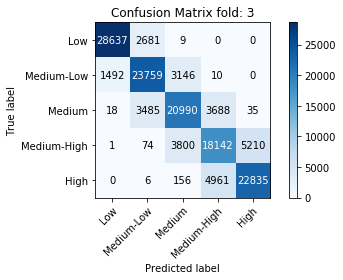

ACCURACY FOLD OBTAIN:     0.798987
PRECISION LOW:            0.949881
PRECISION MEDIUM-LOW:     0.791835
PRECISION MEDIUM:         0.746949
PRECISION MEDIUM-HIGH:    0.676915
PRECISION HIGH:           0.813212
RECALL LOW:               0.914132
RECALL MEDIUM-LOW:        0.836378
RECALL MEDIUM:            0.743904
RECALL MEDIUM-HIGH:       0.666324
RECALL HIGH:              0.816761
ACCURACY OBTAIN:          0.800861

14     	 [9.64441002e-02 5.29535635e-01 8.80942961e-01 1.00000000e+00
 2.28000000e+02 2.38000000e+02 7.60000000e+01 3.00000000e+00]. 	  0.8008607029914856 	 0.8008607029914856


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adadelta
TRY LEARNING RATE:   0.09006
TRY RHO:             0.21706
TRY NUMBER LAYERS:       1
TRY FIRST LAYER:       279

RUN NUMBER:                    21
FOLD NUMBER:                    1


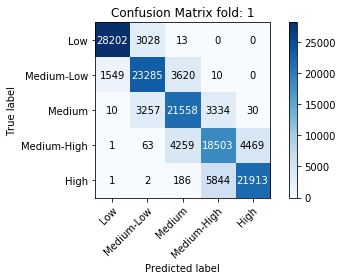

ACCURACY FOLD OBTAIN:     0.792674
PRECISION LOW:            0.947552
PRECISION MEDIUM-LOW:     0.785726
PRECISION MEDIUM:         0.727426
PRECISION MEDIUM-HIGH:    0.668195
PRECISION HIGH:           0.829661
RECALL LOW:               0.902666
RECALL MEDIUM-LOW:        0.818051
RECALL MEDIUM:            0.764766
RECALL MEDIUM-HIGH:       0.67789
RECALL HIGH:              0.784119
FOLD NUMBER:                    2


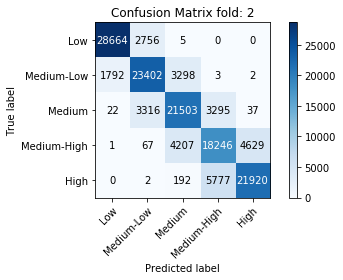

ACCURACY FOLD OBTAIN:     0.794594
PRECISION LOW:            0.940451
PRECISION MEDIUM-LOW:     0.792134
PRECISION MEDIUM:         0.736278
PRECISION MEDIUM-HIGH:    0.667838
PRECISION HIGH:           0.824432
RECALL LOW:               0.91214
RECALL MEDIUM-LOW:        0.821209
RECALL MEDIUM:            0.763249
RECALL MEDIUM-HIGH:       0.672044
RECALL HIGH:              0.785917
FOLD NUMBER:                    3


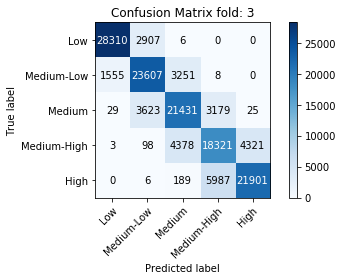

ACCURACY FOLD OBTAIN:     0.793447
PRECISION LOW:            0.946918
PRECISION MEDIUM-LOW:     0.780629
PRECISION MEDIUM:         0.732559
PRECISION MEDIUM-HIGH:    0.666339
PRECISION HIGH:           0.834419
RECALL LOW:               0.906703
RECALL MEDIUM-LOW:        0.830618
RECALL MEDIUM:            0.757627
RECALL MEDIUM-HIGH:       0.675528
RECALL HIGH:              0.779867
ACCURACY OBTAIN:          0.793572

15     	 [9.00617410e-02 5.52476665e-01 2.17058170e-01 1.00000000e+00
 2.79000000e+02 1.11000000e+02 7.40000000e+01 3.00000000e+00]. 	  0.7935715913772583 	 0.8008607029914856


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adagrad
TRY LEARNING RATE:   0.09513
TRY NUMBER LAYERS:       2
TRY FIRST LAYER:       280
TRY SECOND LAYER:      233

RUN NUMBER:                    22
FOLD NUMBER:                    1


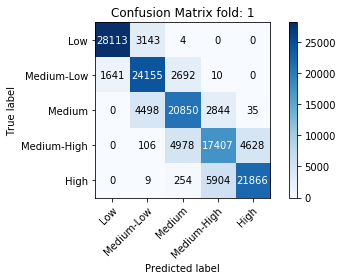

ACCURACY FOLD OBTAIN:     0.785199
PRECISION LOW:            0.944848
PRECISION MEDIUM-LOW:     0.756949
PRECISION MEDIUM:         0.724512
PRECISION MEDIUM-HIGH:    0.665278
PRECISION HIGH:           0.82423
RECALL LOW:               0.899328
RECALL MEDIUM-LOW:        0.847603
RECALL MEDIUM:            0.738654
RECALL MEDIUM-HIGH:       0.641875
RECALL HIGH:              0.780009
FOLD NUMBER:                    2


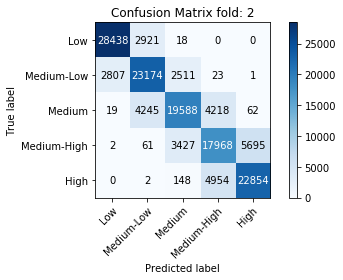

ACCURACY FOLD OBTAIN:     0.782626
PRECISION LOW:            0.90955
PRECISION MEDIUM-LOW:     0.762227
PRECISION MEDIUM:         0.762416
PRECISION MEDIUM-HIGH:    0.661488
PRECISION HIGH:           0.798756
RECALL LOW:               0.906333
RECALL MEDIUM-LOW:        0.812667
RECALL MEDIUM:            0.696289
RECALL MEDIUM-HIGH:       0.661732
RECALL HIGH:              0.81744
FOLD NUMBER:                    3


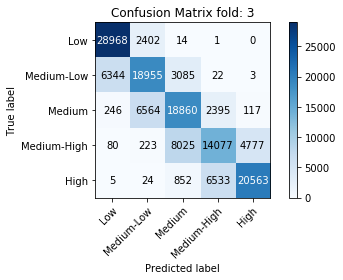

ACCURACY FOLD OBTAIN:     0.708583
PRECISION LOW:            0.812726
PRECISION MEDIUM-LOW:     0.672927
PRECISION MEDIUM:         0.611623
PRECISION MEDIUM-HIGH:    0.611299
PRECISION HIGH:           0.807659
RECALL LOW:               0.922989
RECALL MEDIUM-LOW:        0.667218
RECALL MEDIUM:            0.669221
RECALL MEDIUM-HIGH:       0.517879
RECALL HIGH:              0.734997
ACCURACY OBTAIN:          0.758803

16     	 [9.51256931e-02 8.91241062e-01 8.87977602e-01 2.00000000e+00
 2.80000000e+02 2.33000000e+02 9.80000000e+01 2.00000000e+00]. 	  0.7588026523590088 	 0.8008607029914856


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adagrad
TRY LEARNING RATE:   0.01503
TRY NUMBER LAYERS:       2
TRY FIRST LAYER:       254
TRY SECOND LAYER:      192

RUN NUMBER:                    23
FOLD NUMBER:                    1


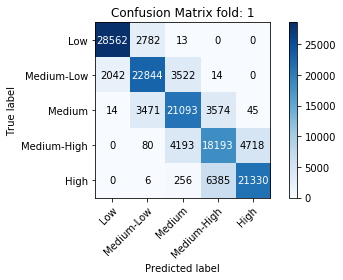

ACCURACY FOLD OBTAIN:     0.782621
PRECISION LOW:            0.93285
PRECISION MEDIUM-LOW:     0.782784
PRECISION MEDIUM:         0.725419
PRECISION MEDIUM-HIGH:    0.645921
PRECISION HIGH:           0.817461
RECALL LOW:               0.910865
RECALL MEDIUM-LOW:        0.803744
RECALL MEDIUM:            0.748058
RECALL MEDIUM-HIGH:       0.669254
RECALL HIGH:              0.762412
FOLD NUMBER:                    2


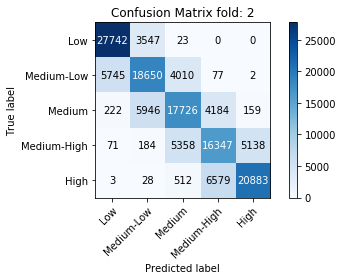

ACCURACY FOLD OBTAIN:     0.708054
PRECISION LOW:            0.821182
PRECISION MEDIUM-LOW:     0.657732
PRECISION MEDIUM:         0.641572
PRECISION MEDIUM-HIGH:    0.60128
PRECISION HIGH:           0.797609
RECALL LOW:               0.885986
RECALL MEDIUM-LOW:        0.654754
RECALL MEDIUM:            0.627758
RECALL MEDIUM-HIGH:       0.603255
RECALL HIGH:              0.745688
FOLD NUMBER:                    3


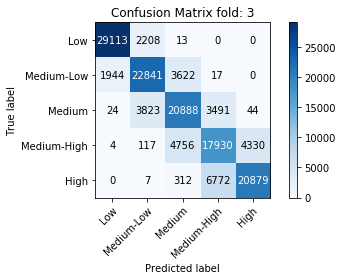

ACCURACY FOLD OBTAIN:     0.78004
PRECISION LOW:            0.936561
PRECISION MEDIUM-LOW:     0.787729
PRECISION MEDIUM:         0.70589
PRECISION MEDIUM-HIGH:    0.63559
PRECISION HIGH:           0.826793
RECALL LOW:               0.929119
RECALL MEDIUM-LOW:        0.803581
RECALL MEDIUM:            0.738875
RECALL MEDIUM-HIGH:       0.660722
RECALL HIGH:              0.746478
ACCURACY OBTAIN:          0.756905

17     	 [1.50278399e-02 4.57239805e-01 6.65696366e-01 2.00000000e+00
 2.54000000e+02 1.92000000e+02 7.70000000e+01 2.00000000e+00]. 	  0.7569048603375753 	 0.8008607029914856


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adagrad
TRY LEARNING RATE:   0.07518
TRY NUMBER LAYERS:       1
TRY FIRST LAYER:       157

RUN NUMBER:                    24
FOLD NUMBER:                    1


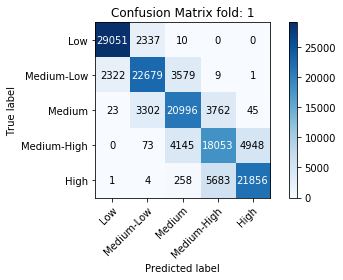

ACCURACY FOLD OBTAIN:     0.786903
PRECISION LOW:            0.925279
PRECISION MEDIUM-LOW:     0.798697
PRECISION MEDIUM:          0.7243
PRECISION MEDIUM-HIGH:    0.656306
PRECISION HIGH:           0.814004
RECALL LOW:               0.92525
RECALL MEDIUM-LOW:        0.793249
RECALL MEDIUM:            0.746445
RECALL MEDIUM-HIGH:       0.66325
RECALL HIGH:              0.78613
FOLD NUMBER:                    2


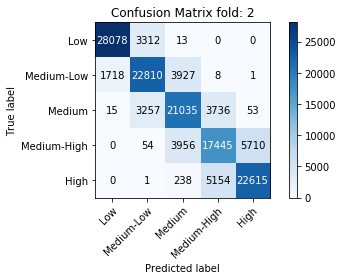

ACCURACY FOLD OBTAIN:     0.782354
PRECISION LOW:            0.941867
PRECISION MEDIUM-LOW:     0.774954
PRECISION MEDIUM:         0.721142
PRECISION MEDIUM-HIGH:    0.662225
PRECISION HIGH:           0.796892
RECALL LOW:               0.894118
RECALL MEDIUM-LOW:        0.801363
RECALL MEDIUM:            0.748683
RECALL MEDIUM-HIGH:       0.642187
RECALL HIGH:              0.807448
FOLD NUMBER:                    3


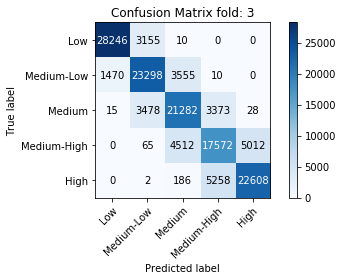

ACCURACY FOLD OBTAIN:     0.789506
PRECISION LOW:            0.950052
PRECISION MEDIUM-LOW:     0.776652
PRECISION MEDIUM:         0.720325
PRECISION MEDIUM-HIGH:    0.670354
PRECISION HIGH:           0.817708
RECALL LOW:               0.899239
RECALL MEDIUM-LOW:        0.822292
RECALL MEDIUM:            0.755324
RECALL MEDIUM-HIGH:       0.646957
RECALL HIGH:              0.805874
ACCURACY OBTAIN:          0.786255

18     	 [7.51826210e-02 5.75597866e-01 2.11685636e-01 1.00000000e+00
 1.57000000e+02 1.73000000e+02 9.90000000e+01 2.00000000e+00]. 	  0.7862545649210612 	 0.8008607029914856


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adadelta
TRY LEARNING RATE:   0.0634
TRY RHO:             0.13885
TRY NUMBER LAYERS:       2
TRY FIRST LAYER:       290
TRY SECOND LAYER:      136

RUN NUMBER:                    25
FOLD NUMBER:                    1


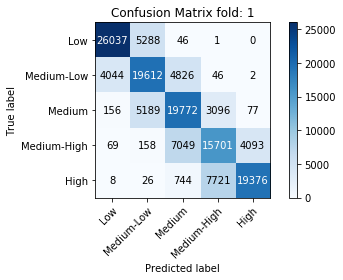

ACCURACY FOLD OBTAIN:     0.702111
PRECISION LOW:            0.85891
PRECISION MEDIUM-LOW:     0.647838
PRECISION MEDIUM:         0.609551
PRECISION MEDIUM-HIGH:    0.591041
PRECISION HIGH:           0.82283
RECALL LOW:               0.829944
RECALL MEDIUM-LOW:        0.687417
RECALL MEDIUM:            0.698904
RECALL MEDIUM-HIGH:       0.580015
RECALL HIGH:              0.695103
FOLD NUMBER:                    2


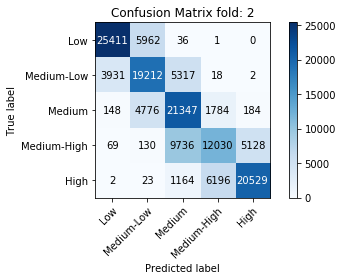

ACCURACY FOLD OBTAIN:     0.688359
PRECISION LOW:            0.859612
PRECISION MEDIUM-LOW:     0.638209
PRECISION MEDIUM:         0.567739
PRECISION MEDIUM-HIGH:    0.600629
PRECISION HIGH:           0.794374
RECALL LOW:               0.80901
RECALL MEDIUM-LOW:        0.674579
RECALL MEDIUM:            0.75594
RECALL MEDIUM-HIGH:       0.444026
RECALL HIGH:              0.735437
FOLD NUMBER:                    3


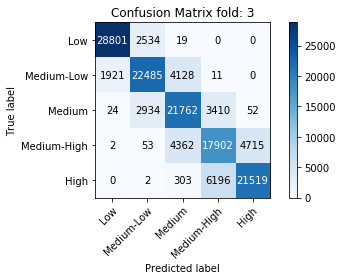

ACCURACY FOLD OBTAIN:     0.785755
PRECISION LOW:            0.936679
PRECISION MEDIUM-LOW:     0.802806
PRECISION MEDIUM:         0.711781
PRECISION MEDIUM-HIGH:    0.650532
PRECISION HIGH:           0.818649
RECALL LOW:               0.918575
RECALL MEDIUM-LOW:        0.787704
RECALL MEDIUM:            0.772195
RECALL MEDIUM-HIGH:       0.662203
RECALL HIGH:              0.767987
ACCURACY OBTAIN:          0.725408

19     	 [6.33950789e-02 7.57296303e-01 1.38845199e-01 2.00000000e+00
 2.90000000e+02 1.36000000e+02 9.40000000e+01 3.00000000e+00]. 	  0.7254081964492798 	 0.8008607029914856


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adadelta
TRY LEARNING RATE:   0.09446
TRY RHO:             0.66963
TRY NUMBER LAYERS:       2
TRY FIRST LAYER:       253
TRY SECOND LAYER:      125

RUN NUMBER:                    26
FOLD NUMBER:                    1


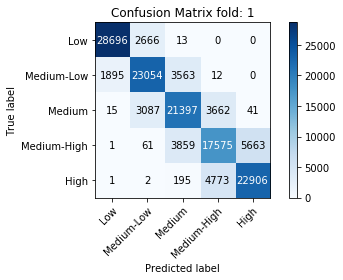

ACCURACY FOLD OBTAIN:     0.793841
PRECISION LOW:            0.937533
PRECISION MEDIUM-LOW:     0.798545
PRECISION MEDIUM:         0.737141
PRECISION MEDIUM-HIGH:    0.67539
PRECISION HIGH:           0.800629
RECALL LOW:               0.914614
RECALL MEDIUM-LOW:        0.808232
RECALL MEDIUM:            0.758705
RECALL MEDIUM-HIGH:       0.647115
RECALL HIGH:              0.821681
FOLD NUMBER:                    2


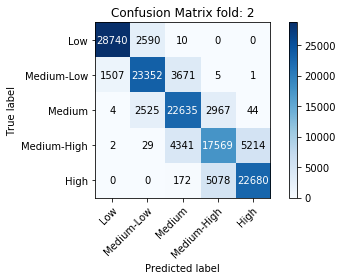

ACCURACY FOLD OBTAIN:     0.803264
PRECISION LOW:            0.949988
PRECISION MEDIUM-LOW:     0.819483
PRECISION MEDIUM:         0.734211
PRECISION MEDIUM-HIGH:    0.68578
PRECISION HIGH:           0.811768
RECALL LOW:               0.917039
RECALL MEDIUM-LOW:        0.818335
RECALL MEDIUM:            0.803372
RECALL MEDIUM-HIGH:       0.64699
RECALL HIGH:              0.81203
FOLD NUMBER:                    3


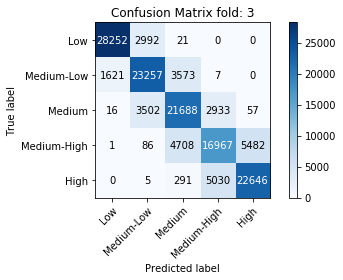

ACCURACY FOLD OBTAIN:     0.788137
PRECISION LOW:            0.945199
PRECISION MEDIUM-LOW:     0.779338
PRECISION MEDIUM:         0.716225
PRECISION MEDIUM-HIGH:    0.680395
PRECISION HIGH:           0.803477
RECALL LOW:               0.90363
RECALL MEDIUM-LOW:        0.817239
RECALL MEDIUM:            0.769187
RECALL MEDIUM-HIGH:       0.622779
RECALL HIGH:              0.809595
ACCURACY OBTAIN:          0.795081

20     	 [9.44592728e-02 1.86439736e-01 6.69629563e-01 2.00000000e+00
 2.53000000e+02 1.25000000e+02 8.50000000e+01 3.00000000e+00]. 	  0.7950806617736816 	 0.8008607029914856


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adadelta
TRY LEARNING RATE:   0.09165
TRY RHO:             0.12927
TRY NUMBER LAYERS:       1
TRY FIRST LAYER:       234

RUN NUMBER:                    27
FOLD NUMBER:                    1


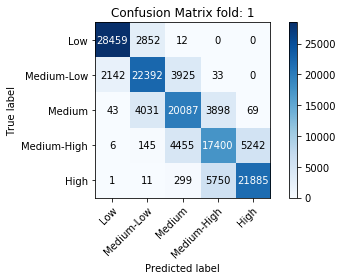

ACCURACY FOLD OBTAIN:     0.770052
PRECISION LOW:            0.928485
PRECISION MEDIUM-LOW:     0.76083
PRECISION MEDIUM:         0.697998
PRECISION MEDIUM-HIGH:    0.642517
PRECISION HIGH:           0.804714
RECALL LOW:               0.908566
RECALL MEDIUM-LOW:        0.785905
RECALL MEDIUM:            0.714128
RECALL MEDIUM-HIGH:       0.638579
RECALL HIGH:              0.783117
FOLD NUMBER:                    2


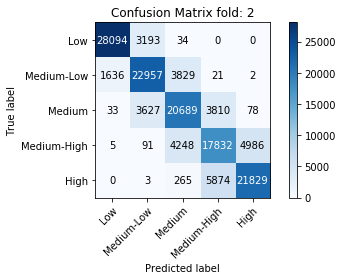

ACCURACY FOLD OBTAIN:     0.778288
PRECISION LOW:            0.943765
PRECISION MEDIUM-LOW:     0.768538
PRECISION MEDIUM:         0.711818
PRECISION MEDIUM-HIGH:    0.647565
PRECISION HIGH:           0.811638
RECALL LOW:               0.89697
RECALL MEDIUM-LOW:        0.807066
RECALL MEDIUM:            0.732691
RECALL MEDIUM-HIGH:       0.656505
RECALL HIGH:              0.780415
FOLD NUMBER:                    3


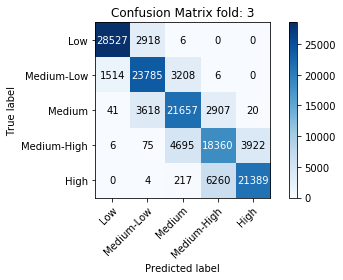

ACCURACY FOLD OBTAIN:     0.794481
PRECISION LOW:            0.948119
PRECISION MEDIUM-LOW:     0.782401
PRECISION MEDIUM:         0.72716
PRECISION MEDIUM-HIGH:    0.666836
PRECISION HIGH:           0.84438
RECALL LOW:               0.90703
RECALL MEDIUM-LOW:        0.834181
RECALL MEDIUM:            0.766809
RECALL MEDIUM-HIGH:       0.678542
RECALL HIGH:              0.767456
ACCURACY OBTAIN:          0.78094

21     	 [9.16520519e-02 7.15682444e-01 1.29272157e-01 1.00000000e+00
 2.34000000e+02 2.03000000e+02 9.80000000e+01 3.00000000e+00]. 	  0.7809403340021769 	 0.8008607029914856


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adadelta
TRY LEARNING RATE:   0.09095
TRY RHO:             0.92223
TRY NUMBER LAYERS:       2
TRY FIRST LAYER:       201
TRY SECOND LAYER:      230

RUN NUMBER:                    28
FOLD NUMBER:                    1


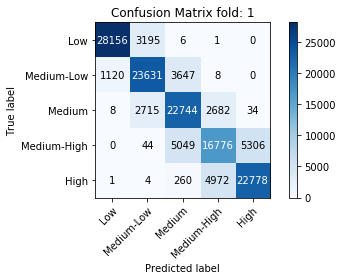

ACCURACY FOLD OBTAIN:     0.797034
PRECISION LOW:            0.961448
PRECISION MEDIUM-LOW:     0.798641
PRECISION MEDIUM:         0.717341
PRECISION MEDIUM-HIGH:    0.686444
PRECISION HIGH:           0.810086
RECALL LOW:               0.897889
RECALL MEDIUM-LOW:        0.831902
RECALL MEDIUM:            0.807011
RECALL MEDIUM-HIGH:       0.617332
RECALL HIGH:              0.813064
FOLD NUMBER:                    2


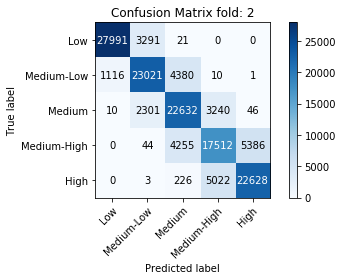

ACCURACY FOLD OBTAIN:     0.794936
PRECISION LOW:            0.961328
PRECISION MEDIUM-LOW:     0.803245
PRECISION MEDIUM:         0.718157
PRECISION MEDIUM-HIGH:    0.679181
PRECISION HIGH:           0.806386
RECALL LOW:               0.894195
RECALL MEDIUM-LOW:        0.806962
RECALL MEDIUM:            0.801729
RECALL MEDIUM-HIGH:       0.643895
RECALL HIGH:              0.81165
FOLD NUMBER:                    3


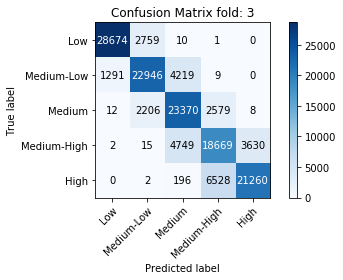

ACCURACY FOLD OBTAIN:     0.802871
PRECISION LOW:            0.95647
PRECISION MEDIUM-LOW:     0.821613
PRECISION MEDIUM:         0.718105
PRECISION MEDIUM-HIGH:    0.671885
PRECISION HIGH:           0.853884
RECALL LOW:               0.911907
RECALL MEDIUM-LOW:        0.806113
RECALL MEDIUM:            0.829459
RECALL MEDIUM-HIGH:       0.689784
RECALL HIGH:              0.759666
ACCURACY OBTAIN:          0.79828

22     	 [9.09542031e-02 7.55383800e-01 9.22230083e-01 2.00000000e+00
 2.01000000e+02 2.30000000e+02 6.50000000e+01 3.00000000e+00]. 	  0.7982804377873739 	 0.8008607029914856


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adagrad
TRY LEARNING RATE:   0.09634
TRY NUMBER LAYERS:       1
TRY FIRST LAYER:       214

RUN NUMBER:                    29
FOLD NUMBER:                    1


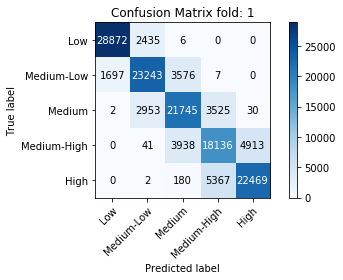

ACCURACY FOLD OBTAIN:     0.799688
PRECISION LOW:            0.944424
PRECISION MEDIUM-LOW:     0.810595
PRECISION MEDIUM:         0.738496
PRECISION MEDIUM-HIGH:    0.670834
PRECISION HIGH:           0.819678
RECALL LOW:               0.922045
RECALL MEDIUM-LOW:        0.814886
RECALL MEDIUM:            0.769598
RECALL MEDIUM-HIGH:       0.671008
RECALL HIGH:              0.801949
FOLD NUMBER:                    2


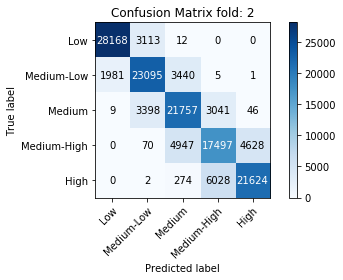

ACCURACY FOLD OBTAIN:     0.783458
PRECISION LOW:            0.934014
PRECISION MEDIUM-LOW:     0.778186
PRECISION MEDIUM:         0.714985
PRECISION MEDIUM-HIGH:     0.6585
PRECISION HIGH:           0.822237
RECALL LOW:               0.900137
RECALL MEDIUM-LOW:        0.809726
RECALL MEDIUM:            0.770132
RECALL MEDIUM-HIGH:       0.644647
RECALL HIGH:              0.774277
FOLD NUMBER:                    3


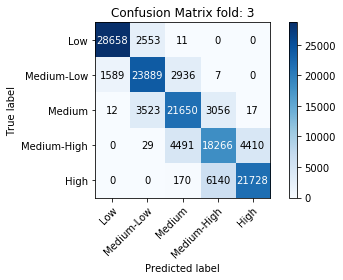

ACCURACY FOLD OBTAIN:     0.797785
PRECISION LOW:            0.94709
PRECISION MEDIUM-LOW:     0.796459
PRECISION MEDIUM:         0.739969
PRECISION MEDIUM-HIGH:    0.664968
PRECISION HIGH:           0.83074
RECALL LOW:               0.917878
RECALL MEDIUM-LOW:        0.84054
RECALL MEDIUM:            0.766155
RECALL MEDIUM-HIGH:       0.671643
RECALL HIGH:              0.774948
ACCURACY OBTAIN:          0.793644

23     	 [9.63426502e-02 7.09859821e-01 3.19868635e-01 1.00000000e+00
 2.14000000e+02 1.68000000e+02 5.60000000e+01 2.00000000e+00]. 	  0.7936437924702963 	 0.8008607029914856


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adagrad
TRY LEARNING RATE:   0.03238
TRY NUMBER LAYERS:       1
TRY FIRST LAYER:       201

RUN NUMBER:                    30
FOLD NUMBER:                    1


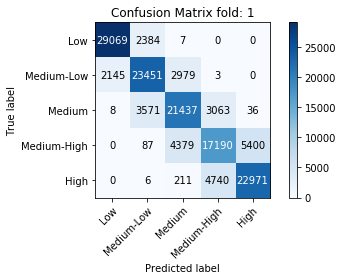

ACCURACY FOLD OBTAIN:     0.797264
PRECISION LOW:            0.931042
PRECISION MEDIUM-LOW:     0.794976
PRECISION MEDIUM:         0.738876
PRECISION MEDIUM-HIGH:    0.68771
PRECISION HIGH:           0.808639
RECALL LOW:               0.923999
RECALL MEDIUM-LOW:        0.820596
RECALL MEDIUM:            0.762476
RECALL MEDIUM-HIGH:       0.635349
RECALL HIGH:              0.822508
FOLD NUMBER:                    2


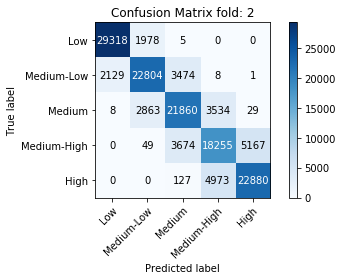

ACCURACY FOLD OBTAIN:     0.804249
PRECISION LOW:            0.932062
PRECISION MEDIUM-LOW:     0.823427
PRECISION MEDIUM:         0.750172
PRECISION MEDIUM-HIGH:    0.68192
PRECISION HIGH:           0.814902
RECALL LOW:               0.936647
RECALL MEDIUM-LOW:        0.802506
RECALL MEDIUM:            0.772602
RECALL MEDIUM-HIGH:        0.6725
RECALL HIGH:              0.817727
FOLD NUMBER:                    3


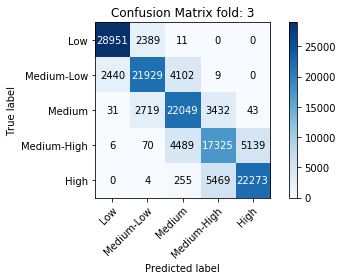

ACCURACY FOLD OBTAIN:     0.78616
PRECISION LOW:            0.921185
PRECISION MEDIUM-LOW:     0.80886
PRECISION MEDIUM:         0.713421
PRECISION MEDIUM-HIGH:    0.660377
PRECISION HIGH:           0.811255
RECALL LOW:               0.923447
RECALL MEDIUM-LOW:        0.769979
RECALL MEDIUM:            0.779833
RECALL MEDIUM-HIGH:       0.640978
RECALL HIGH:              0.795436
ACCURACY OBTAIN:          0.795891

24     	 [3.23849165e-02 1.02761867e-01 3.20091271e-01 1.00000000e+00
 2.01000000e+02 1.35000000e+02 8.80000000e+01 2.00000000e+00]. 	  0.7958910663922628 	 0.8008607029914856


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adagrad
TRY LEARNING RATE:   0.04498
TRY NUMBER LAYERS:       1
TRY FIRST LAYER:       181

RUN NUMBER:                    31
FOLD NUMBER:                    1


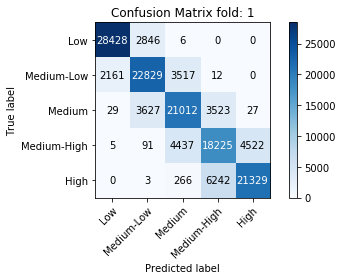

ACCURACY FOLD OBTAIN:     0.781231
PRECISION LOW:            0.928322
PRECISION MEDIUM-LOW:     0.776602
PRECISION MEDIUM:         0.718654
PRECISION MEDIUM-HIGH:    0.650846
PRECISION HIGH:           0.824214
RECALL LOW:               0.908824
RECALL MEDIUM-LOW:        0.800484
RECALL MEDIUM:            0.744631
RECALL MEDIUM-HIGH:       0.668072
RECALL HIGH:              0.766128
FOLD NUMBER:                    2


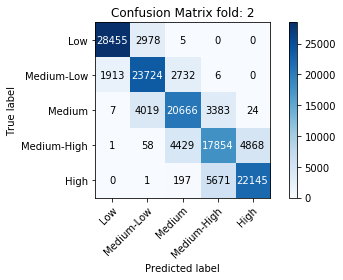

ACCURACY FOLD OBTAIN:     0.788369
PRECISION LOW:            0.936759
PRECISION MEDIUM-LOW:     0.77076
PRECISION MEDIUM:         0.737308
PRECISION MEDIUM-HIGH:    0.663372
PRECISION HIGH:           0.819063
RECALL LOW:               0.905115
RECALL MEDIUM-LOW:        0.836088
RECALL MEDIUM:            0.735471
RECALL MEDIUM-HIGH:       0.656156
RECALL HIGH:              0.790498
FOLD NUMBER:                    3


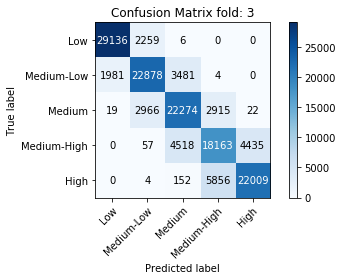

ACCURACY FOLD OBTAIN:     0.799665
PRECISION LOW:            0.935766
PRECISION MEDIUM-LOW:     0.812314
PRECISION MEDIUM:         0.731951
PRECISION MEDIUM-HIGH:    0.674252
PRECISION HIGH:           0.831595
RECALL LOW:               0.927869
RECALL MEDIUM-LOW:        0.807155
RECALL MEDIUM:            0.78997
RECALL MEDIUM-HIGH:       0.668421
RECALL HIGH:              0.785447
ACCURACY OBTAIN:          0.789755

25     	 [4.49793293e-02 7.28373069e-01 3.18592734e-01 1.00000000e+00
 1.81000000e+02 1.46000000e+02 7.80000000e+01 2.00000000e+00]. 	  0.7897547880808512 	 0.8008607029914856


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:         SGD
TRY LEARNING RATE:   0.08562
TRY MOMENTUM:        0.11928
TRY NUMBER LAYERS:       2
TRY FIRST LAYER:       153
TRY SECOND LAYER:      220

RUN NUMBER:                    32
FOLD NUMBER:                    1


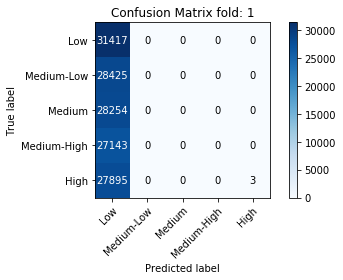

ACCURACY FOLD OBTAIN:     0.21951
PRECISION LOW:            0.219494


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


PRECISION MEDIUM-LOW:         0.0
PRECISION MEDIUM:             0.0
PRECISION MEDIUM-HIGH:        0.0
PRECISION HIGH:               1.0
RECALL LOW:                   1.0
RECALL MEDIUM-LOW:            0.0
RECALL MEDIUM:                0.0
RECALL MEDIUM-HIGH:           0.0
RECALL HIGH:              0.000108
FOLD NUMBER:                    2


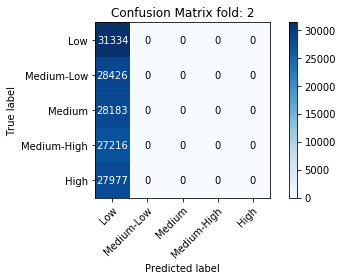

ACCURACY FOLD OBTAIN:     0.218911
PRECISION LOW:            0.218911


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


PRECISION MEDIUM-LOW:         0.0
PRECISION MEDIUM:             0.0
PRECISION MEDIUM-HIGH:        0.0
PRECISION HIGH:               0.0
RECALL LOW:                   1.0
RECALL MEDIUM-LOW:            0.0
RECALL MEDIUM:                0.0
RECALL MEDIUM-HIGH:           0.0
RECALL HIGH:                  0.0
FOLD NUMBER:                    3


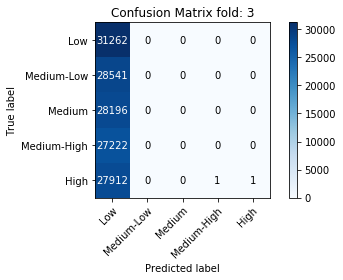

ACCURACY FOLD OBTAIN:     0.218416
PRECISION LOW:            0.218412


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


PRECISION MEDIUM-LOW:         0.0
PRECISION MEDIUM:             0.0
PRECISION MEDIUM-HIGH:        0.0
PRECISION HIGH:               1.0
RECALL LOW:                   1.0
RECALL MEDIUM-LOW:            0.0
RECALL MEDIUM:                0.0
RECALL MEDIUM-HIGH:           0.0
RECALL HIGH:              3.6e-05
ACCURACY OBTAIN:          0.218946

26     	 [8.56157347e-02 1.19282738e-01 6.51954848e-01 2.00000000e+00
 1.53000000e+02 2.20000000e+02 7.80000000e+01 0.00000000e+00]. 	  0.21894561251004538 	 0.8008607029914856


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adadelta
TRY LEARNING RATE:   0.00789
TRY RHO:             0.89507
TRY NUMBER LAYERS:       1
TRY FIRST LAYER:       255

RUN NUMBER:                    33
FOLD NUMBER:                    1


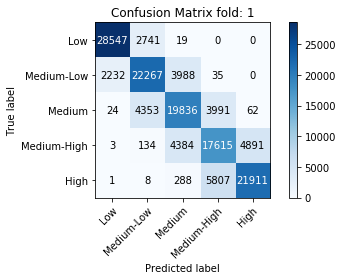

ACCURACY FOLD OBTAIN:     0.769724
PRECISION LOW:            0.92664
PRECISION MEDIUM-LOW:     0.754737
PRECISION MEDIUM:         0.695634
PRECISION MEDIUM-HIGH:    0.641759
PRECISION HIGH:           0.815627
RECALL LOW:               0.911841
RECALL MEDIUM-LOW:        0.780696
RECALL MEDIUM:            0.701762
RECALL MEDIUM-HIGH:       0.651756
RECALL HIGH:              0.782117
FOLD NUMBER:                    2


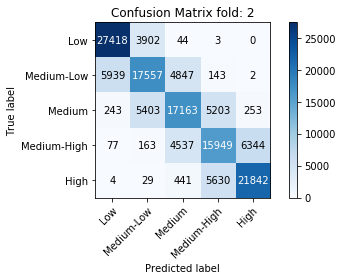

ACCURACY FOLD OBTAIN:     0.69814
PRECISION LOW:            0.814049
PRECISION MEDIUM-LOW:     0.648961
PRECISION MEDIUM:         0.634914
PRECISION MEDIUM-HIGH:    0.592283
PRECISION HIGH:           0.767976
RECALL LOW:               0.874103
RECALL MEDIUM-LOW:        0.616295
RECALL MEDIUM:            0.607217
RECALL MEDIUM-HIGH:       0.589176
RECALL HIGH:              0.781579
FOLD NUMBER:                    3


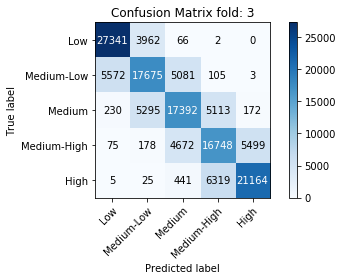

ACCURACY FOLD OBTAIN:     0.700877
PRECISION LOW:            0.822954
PRECISION MEDIUM-LOW:     0.651373
PRECISION MEDIUM:         0.62896
PRECISION MEDIUM-HIGH:    0.592074
PRECISION HIGH:           0.788583
RECALL LOW:               0.871537
RECALL MEDIUM-LOW:        0.621571
RECALL MEDIUM:            0.616694
RECALL MEDIUM-HIGH:       0.61637
RECALL HIGH:              0.757101
ACCURACY OBTAIN:          0.722914

27     	 [7.88669693e-03 6.58760499e-01 8.95065561e-01 1.00000000e+00
 2.55000000e+02 2.01000000e+02 9.90000000e+01 3.00000000e+00]. 	  0.7229137023289999 	 0.8008607029914856


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adadelta
TRY LEARNING RATE:   0.08796
TRY RHO:             0.42783
TRY NUMBER LAYERS:       2
TRY FIRST LAYER:       299
TRY SECOND LAYER:      225

RUN NUMBER:                    34
FOLD NUMBER:                    1


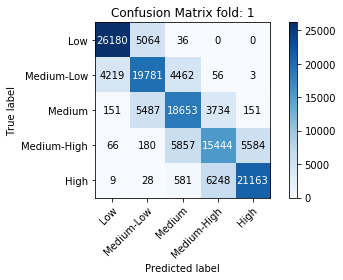

ACCURACY FOLD OBTAIN:     0.707162
PRECISION LOW:            0.854857
PRECISION MEDIUM-LOW:     0.647708
PRECISION MEDIUM:         0.630403
PRECISION MEDIUM-HIGH:    0.606075
PRECISION HIGH:           0.786699
RECALL LOW:               0.836957
RECALL MEDIUM-LOW:        0.693559
RECALL MEDIUM:            0.662017
RECALL MEDIUM-HIGH:       0.569238
RECALL HIGH:              0.755039
FOLD NUMBER:                    2


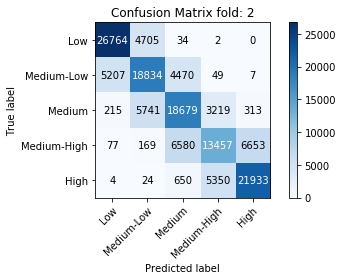

ACCURACY FOLD OBTAIN:     0.69631
PRECISION LOW:            0.829454
PRECISION MEDIUM-LOW:     0.639026
PRECISION MEDIUM:         0.614178
PRECISION MEDIUM-HIGH:    0.609548
PRECISION HIGH:           0.75877
RECALL LOW:               0.849516
RECALL MEDIUM-LOW:        0.659292
RECALL MEDIUM:            0.663152
RECALL MEDIUM-HIGH:       0.499592
RECALL HIGH:              0.784414
FOLD NUMBER:                    3


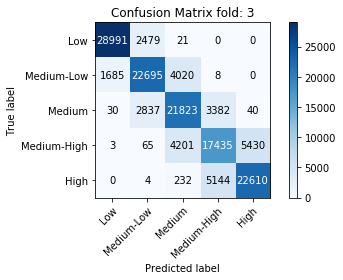

ACCURACY FOLD OBTAIN:     0.793335
PRECISION LOW:            0.944055
PRECISION MEDIUM-LOW:     0.808226
PRECISION MEDIUM:         0.720302
PRECISION MEDIUM-HIGH:    0.671377
PRECISION HIGH:           0.805199
RECALL LOW:               0.920612
RECALL MEDIUM-LOW:        0.798895
RECALL MEDIUM:            0.776288
RECALL MEDIUM-HIGH:       0.642552
RECALL HIGH:              0.807788
ACCURACY OBTAIN:          0.732269

28     	 [8.79649969e-02 1.33369927e-01 4.27833075e-01 2.00000000e+00
 2.99000000e+02 2.25000000e+02 5.40000000e+01 3.00000000e+00]. 	  0.7322688102722168 	 0.8008607029914856


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adadelta
TRY LEARNING RATE:   0.0551
TRY RHO:             0.89752
TRY NUMBER LAYERS:       1
TRY FIRST LAYER:       255

RUN NUMBER:                    35
FOLD NUMBER:                    1


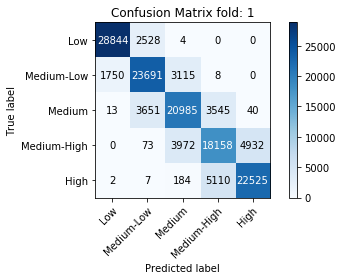

ACCURACY FOLD OBTAIN:     0.797858
PRECISION LOW:            0.942337
PRECISION MEDIUM-LOW:     0.791018
PRECISION MEDIUM:         0.742569
PRECISION MEDIUM-HIGH:    0.677007
PRECISION HIGH:           0.81918
RECALL LOW:               0.919301
RECALL MEDIUM-LOW:        0.829401
RECALL MEDIUM:            0.743253
RECALL MEDIUM-HIGH:       0.669173
RECALL HIGH:              0.809437
FOLD NUMBER:                    2


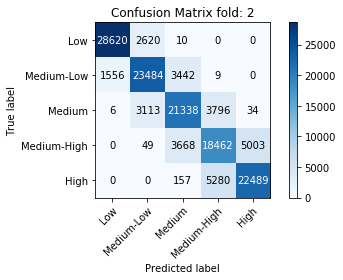

ACCURACY FOLD OBTAIN:     0.799191
PRECISION LOW:            0.948247
PRECISION MEDIUM-LOW:     0.802433
PRECISION MEDIUM:         0.745693
PRECISION MEDIUM-HIGH:     0.6702
PRECISION HIGH:           0.817009
RECALL LOW:               0.91584
RECALL MEDIUM-LOW:        0.82426
RECALL MEDIUM:            0.754339
RECALL MEDIUM-HIGH:       0.679199
RECALL HIGH:              0.805307
FOLD NUMBER:                    3


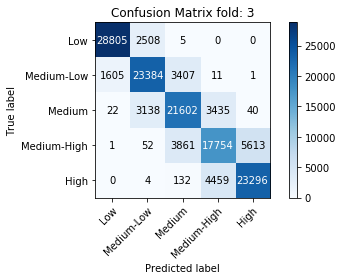

ACCURACY FOLD OBTAIN:     0.802327
PRECISION LOW:            0.946505
PRECISION MEDIUM-LOW:     0.803961
PRECISION MEDIUM:         0.744717
PRECISION MEDIUM-HIGH:    0.691921
PRECISION HIGH:           0.804698
RECALL LOW:               0.919759
RECALL MEDIUM-LOW:        0.823148
RECALL MEDIUM:            0.765025
RECALL MEDIUM-HIGH:       0.650783
RECALL HIGH:              0.835252
ACCURACY OBTAIN:          0.799792

29     	 [5.50988566e-02 4.77417720e-01 8.97519135e-01 1.00000000e+00
 2.55000000e+02 1.27000000e+02 9.30000000e+01 3.00000000e+00]. 	  0.7997918327649435 	 0.8008607029914856


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TRY OPTIMIERS:       Adadelta
TRY LEARNING RATE:   0.07778
TRY RHO:             0.61441
TRY NUMBER LAYERS:       1
TRY FIRST LAYER:       268

RUN NUMBER:                    36
FOLD NUMBER:                    1


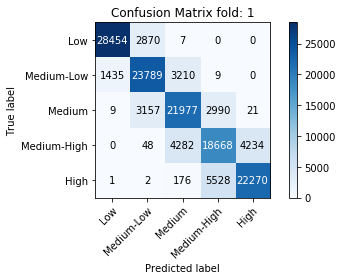

ACCURACY FOLD OBTAIN:     0.80453
PRECISION LOW:            0.951671
PRECISION MEDIUM-LOW:     0.796524
PRECISION MEDIUM:         0.741164
PRECISION MEDIUM-HIGH:    0.68645
PRECISION HIGH:           0.839585
RECALL LOW:               0.908174
RECALL MEDIUM-LOW:        0.836375
RECALL MEDIUM:             0.7806
RECALL MEDIUM-HIGH:       0.685517
RECALL HIGH:              0.796011
FOLD NUMBER:                    2


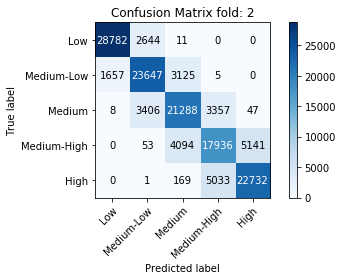

ACCURACY FOLD OBTAIN:     0.799135
PRECISION LOW:            0.945315
PRECISION MEDIUM-LOW:     0.79483
PRECISION MEDIUM:         0.742078
PRECISION MEDIUM-HIGH:    0.681174
PRECISION HIGH:           0.814183
RECALL LOW:               0.915545
RECALL MEDIUM-LOW:        0.831645
RECALL MEDIUM:            0.757418
RECALL MEDIUM-HIGH:       0.65883
RECALL HIGH:              0.813746
FOLD NUMBER:                    3


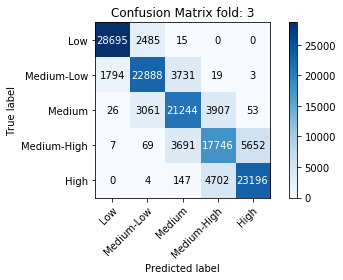

ACCURACY FOLD OBTAIN:     0.794837
PRECISION LOW:            0.940142
PRECISION MEDIUM-LOW:     0.802891
PRECISION MEDIUM:         0.736922
PRECISION MEDIUM-HIGH:    0.67286
PRECISION HIGH:           0.802519
RECALL LOW:               0.919859
RECALL MEDIUM-LOW:        0.804924
RECALL MEDIUM:            0.75091
RECALL MEDIUM-HIGH:       0.653267
RECALL HIGH:              0.826981
ACCURACY OBTAIN:          0.799501

30     	 [7.77789799e-02 7.80316159e-01 6.14409342e-01 1.00000000e+00
 2.68000000e+02 2.17000000e+02 6.70000000e+01 3.00000000e+00]. 	  0.7995006839434305 	 0.8008607029914856


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [33]:
bo.run(max_iter=30, init_evals=1, resume=False)

In [37]:
print(len(best_seen))
print(best_seen[-1])

36
0.8008607029914856


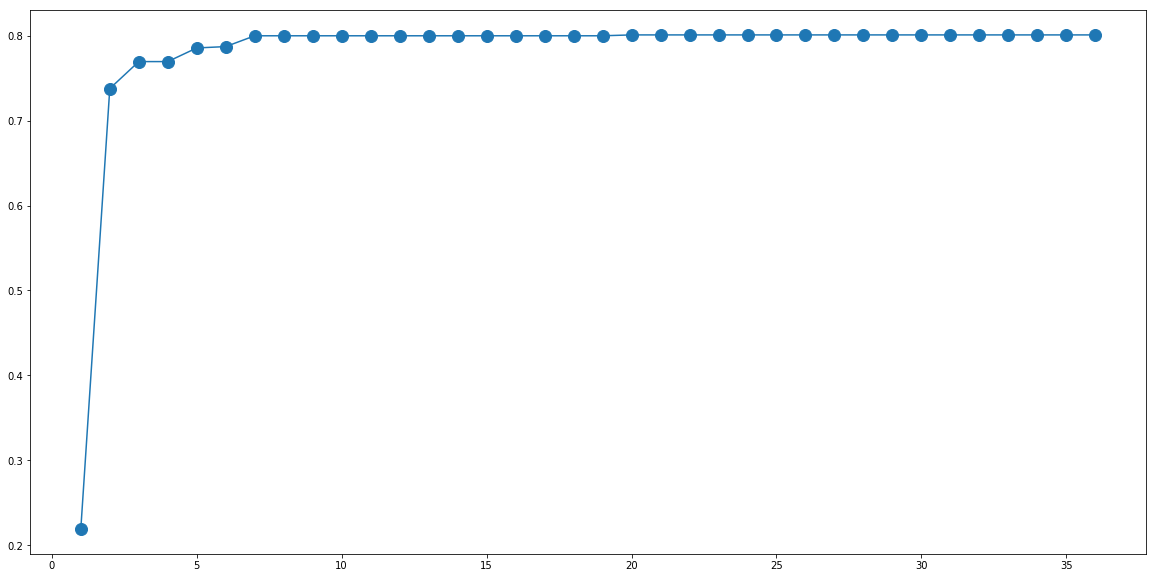

In [45]:
plt.figure(figsize=(20,10))
turn = list()
for i in range(36):
    turn.append(i+1)

plt.plot(turn, best_seen, 'o-', markersize=12, label='Best Seen')

In [18]:
print(typology_data.assists.unique())

[0 1 2 3 4 5]


In [22]:
typology_data.longestKill

4           58.530
7            0.000
13          49.830
17          36.000
35          22.830
48          29.080
59          21.860
89           0.000
101         99.230
106          0.000
109          0.000
111          0.000
117          0.000
126         52.750
137          0.000
139          0.000
141          0.000
142         79.950
147          0.000
177          0.000
182         63.890
186        158.900
194         23.290
202          0.000
209          0.000
211          0.000
228          0.000
274          0.000
286         11.680
291         62.850
            ...   
4446786      0.000
4446797      0.000
4446799      0.000
4446812      0.000
4446816     44.430
4446819      0.000
4446826      0.000
4446832     82.630
4446845     53.240
4446849      0.000
4446850     24.030
4446864     99.150
4446865      0.000
4446874      0.000
4446879     86.890
4446882      0.000
4446891      0.000
4446900      0.000
4446903     31.290
4446909      0.000
4446910     12.910
4446918     